# Volatility analyses

For these analyses we want to compare the same tooth from the same individual taken over muliple time points to determine the degree of change. Is there a major difference between individuals of different HIV status groups?

## 1. Set up environment, load data

In [1]:
# install.packages("compositions")
# install.packages("ggdist")
library(phyloseq, verbose=F)
library(ggplot2, verbose=F)
library(compositions, verbose=F)
library(reshape2, verbose=F)
library(tidyr, verbose=F)
library(dplyr, verbose=F)
library(ggdist, verbose=F)
library(ggpubr, verbose=F)
# load in master phyloseq R data object
load("../02-diversity/master_phyloseq.RData")
# set up directory to save figures
system("mkdir img")
# check phyloseq object
ps.dat
# pull metadata table
map <- sample_data(ps.dat)

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following object is masked from ‘package:graphics’:

    segments


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

In [2]:
# save old parameters so you can mess around with figure size etc
oldpar <- par(no.readonly = TRUE)

## 2. Filter data to include only those teeth with multiple samplings across visits

#### First, create a column in our metadata that combines the study ID (individual ID) and the FDI tooth code

In [3]:
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")

#### From these, can now pull samples from visit one and visit two, filter the data to get those that we want to analyze

In [4]:
# pull visit one and visit two
map.v1v2 <- map[map$visit_num == 1 | map$visit_num == 2,]
# count the number of times that a study ID + FDI code appears in the data
counts <- data.frame(table(map.v1v2$studyID_FDI))
# pull records that occur more than one time
map.v1v2 <- map.v1v2[map.v1v2$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
# reorder
map.v1v2 <- map.v1v2[order(map.v1v2$studyID_FDI),]
# how many samples meet these criteria?
dim(map.v1v2)
# make sure you aren't left with singletons, this command should come back as all TRUE
# data.frame(table(map.v1v2$studyID_FDI))$Freq == 2

[1] 368  27

In [5]:
head(map.v1v2)

,DNA_ng.ul,rpoC_amplicon_count,study_id,cd4_count,cd4_group,FDI_code,tooth_type,tooth_age,tooth_location,visit_num,⋯,hiv_status,sex,study,i5_index_id,index1,i7_index_id,index2,file_R1,file_R2,studyID_FDI
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DM00008V1PQ16-2,11.6,36692,DM00008,698,normal,16,molar,adult,upper_right,1,⋯,HI,F,DOMHaIN,SA501,ATCGTACG,SA702,ACTATGTC,DM00008V1PQ16-2_S9_L001_R1_001.fastq.gz,DM00008V1PQ16-2_S9_L001_R2_001.fastq.gz,DM00008.16
DM00008V2PQ16,0.88,21927,DM00008,2168,high,16,molar,adult,upper_right,2,⋯,HI,F,DOMHaIN,SA507,GGATATCT,SA705,CGTACTCA,DM00008V2PQ16_S39_L001_R1_001.fastq.gz,DM00008V2PQ16_S39_L001_R2_001.fastq.gz,DM00008.16
DM00011V1PQ55-1,2.02,18608,DM00011,1237,normal,55,premolar,deciduous,upper_right,1,⋯,HI,F,DOMHaIN,SA507,GGATATCT,SA702,ACTATGTC,DM00011V1PQ55-1_S15_L001_R1_001.fastq.gz,DM00011V1PQ55-1_S15_L001_R2_001.fastq.gz,DM00011.55
DM00011V2PQ55,0.344,18405,DM00011,981,normal,55,premolar,deciduous,upper_right,2,⋯,HI,F,DOMHaIN,SA502,ACTATCTG,SA706,CTACGCAG,DM00011V2PQ55_S42_L001_R1_001.fastq.gz,DM00011V2PQ55_S42_L001_R2_001.fastq.gz,DM00011.55
DM00014V1PQ64-2,0.992,21072,DM00014,778,normal,64,premolar,deciduous,upper_left,1,⋯,HI,M,DOMHaIN,SA505,TCATCGAG,SA703,AGTAGCGT,DM00014V1PQ64-2_S21_L001_R1_001.fastq.gz,DM00014V1PQ64-2_S21_L001_R2_001.fastq.gz,DM00014.64
DM00014V2PQ64,0.105,7886,DM00014,791,normal,64,premolar,deciduous,upper_left,2,⋯,HI,M,DOMHaIN,SA508,GACACCGT,SA706,CTACGCAG,DM00014V2PQ64_S48_L001_R1_001.fastq.gz,DM00014V2PQ64_S48_L001_R2_001.fastq.gz,DM00014.64


#### What is the average number of days between visit one and visit two?

In [6]:
# first melt visit date column into a data frame of two columns
dates <- as.data.frame(matrix(map.v1v2$visit_date, ncol=2, byrow=TRUE))
# average difference between date of visit one and visit two
mean(as.Date(as.character(dates$V2), format="%m/%d/%Y")-as.Date(as.character(dates$V1), format="%m/%d/%Y"))

Time difference of 182.3696 days

#### Do the same thing with visit two and three

In [7]:
## visit two and three? might be able to merge them with v1 and v2 if similar time between sampling
map.v2v3 <- map[map$visit_num == 2 | map$visit_num == 3,]
# count the number of times that a study ID + FDI code appears in the data
counts <- data.frame(table(map.v2v3$studyID_FDI))
# pull records that occur more than one time
map.v2v3 <- map.v2v3[map.v2v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
# reorder
map.v2v3 <- map.v2v3[order(map.v2v3$studyID_FDI),]
# how many samples?
dim(map.v2v3)
# make sure you aren't left with singletons, this command should come back as all TRUE
# data.frame(table(map.v2v3$studyID_FDI))$Freq == 2

# get average number of days between visits
# first melt visit date column into a data frame of two columns
dates <- as.data.frame(matrix(map.v2v3$visit_date, ncol=2, byrow=TRUE))
# average difference between date of visit one and visit two
mean(as.Date(as.character(dates$V2), format="%m/%d/%Y")-as.Date(as.character(dates$V1), format="%m/%d/%Y"))
# a little longer than visit one to two, but still half as long as visit one to three. keep separate for now, might merge in future?

[1] 510  27

Time difference of 222.2471 days

#### And finally, for visit one to three

In [8]:
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
# count the number of times that a study ID + FDI code appears in the data
counts <- data.frame(table(map.v1v3$studyID_FDI))
# pull records that occur more than one time
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
# reorder
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
# number of samples
dim(map.v1v3)
# make sure you aren't left with singletons, this command should come back as all TRUE
# data.frame(table(map.v1v3$studyID_FDI))$Freq == 2

# get average number of days between visits
# first melt visit date column into a data frame of two columns
dates <- as.data.frame(matrix(map.v1v3$visit_date, ncol=2, byrow=TRUE))
# average difference between date of visit one and visit two
mean(as.Date(as.character(dates$V2), format="%m/%d/%Y")-as.Date(as.character(dates$V1), format="%m/%d/%Y"))

[1] 408  27

Time difference of 400.701 days

#### How many teeth changed in health for each group?

In [9]:
# first with just HI from visit one and visit two
temp <- as_tibble(map.v1v2[map.v1v2$hiv_status == "HI",])

paste("HI changes V1 --> V2")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
temp$change <- paste(temp$visit1, "to", temp$visit2)
temp %>%
    count(change)

[1] "HI changes V1 --> V2"

change,n
<chr>,<int>
D-CD to D-CD,7
D-CD to E-CD,1
D-CD to E-CE,1
E-CD to D-CD,1
E-CD to E-CD,3
E-CD to H-CD,2
E-CE to D-CD,1
E-CE to E-CD,1
E-CE to E-CE,1


In [10]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]


studyID_FDI,visit1,visit2,change
<chr>,<chr>,<chr>,<chr>
DM00022.16,H-CD,H-CF,H-CD to H-CF
DM00102.16,H-CD,H-CF,H-CD to H-CF
DM00103.16,E-CD,H-CD,E-CD to H-CD
DM00103.36,D-CD,E-CD,D-CD to E-CD
DM00106.85,D-CD,E-CE,D-CD to E-CE
DM00112.75,H-CD,H-CF,H-CD to H-CF
DM00280.26,H-CE,H-CF,H-CE to H-CF
DM00307.85,E-CD,H-CD,E-CD to H-CD
DM00422.26,H-CD,H-CE,H-CD to H-CE


In [11]:
# HEU visit one to visit two
# map.v1v2[map.v1v2$studyID_FDI == "DM00275.55",]$hiv_status # for troubleshooting
temp <- as_tibble(map.v1v2[map.v1v2$hiv_status == "HEU",])
paste("HEU changes V1 --> V2")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
temp$change <- paste(temp$visit1, "to", temp$visit2)
temp %>%
    count(change)

[1] "HEU changes V1 --> V2"

change,n
<chr>,<int>
D-CD to D-CD,4
D-CD to E-CD,1
E-CD to D-CD,1
H-CD to H-CD,1
H-CE to D-CD,1
H-CE to H-CE,1
H-CE to H-CF,1
H-CF to H-CF,43
H-CF to NA,1


In [12]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit1,visit2,change
<chr>,<chr>,<chr>,<chr>
DM00305.64,D-CD,E-CD,D-CD to E-CD
DM00327.16,H-CE,H-CF,H-CE to H-CF


In [13]:
# map.v1v2[map.v1v2$studyID_FDI == "DM00275.55",]$hiv_status # for debugging

temp <- as_tibble(map.v1v2[map.v1v2$hiv_status == "HUU",])

paste("HUU changes V1 --> V2")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
# print(temp, n=65) # for troubleshooting
temp$change <- paste(temp$visit1, "to", temp$visit2)

temp %>%
    count(change)

[1] "HUU changes V1 --> V2"

change,n
<chr>,<int>
D-CD to D-CD,9
E-CD to D-CD,2
E-CD to E-CD,4
E-CD to E-CE,1
E-CD to H-CD,1
E-CE to E-CE,1
H-CD to E-CD,1
H-CD to E-CE,1
H-CD to H-CD,4


In [14]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit1,visit2,change
<chr>,<chr>,<chr>,<chr>
DM00023.16,H-CD,H-CF,H-CD to H-CF
DM00055.55,H-CE,H-CF,H-CE to H-CF
DM00059.55,H-CE,H-CF,H-CE to H-CF
DM00065.36,H-CE,H-CF,H-CE to H-CF
DM00089.16,H-CD,H-CF,H-CD to H-CF
DM00254.55,E-CD,H-CD,E-CD to H-CD
DM00264.75,E-CD,E-CE,E-CD to E-CE


Visit two to three

In [15]:
# HI from visit 2 to visit 3
temp <- as_tibble(map.v2v3[map.v2v3$hiv_status == "HI",])

paste("HI changes V2 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit2", "visit3")
temp$change <- paste(temp$visit2, "to", temp$visit3)
temp %>%
    count(change)


[1] "HI changes V2 --> V3"

change,n
<chr>,<int>
D-CD to D-CD,9
D-CD to E-CE,1
D-CD to H-CE,1
E-CD to D-CD,1
E-CD to E-CD,3
E-CD to E-CE,2
E-CD to H-CD,1
E-CE to D-CD,4
E-CE to E-CE,2


In [16]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit2,visit3,change
<chr>,<chr>,<chr>,<chr>
DM00208.16,H-CE,H-CF,H-CE to H-CF
DM00263.16,H-CD,H-CE,H-CD to H-CE
DM00263.85,E-CD,E-CE,E-CD to E-CE
DM00301.16,H-CD,H-CE,H-CD to H-CE
DM00301.46,E-CD,E-CE,E-CD to E-CE
DM00361.16,H-CE,H-CF,H-CE to H-CF
DM00459.54,D-CD,E-CE,D-CD to E-CE
DM00488.55,E-CD,H-CD,E-CD to H-CD


In [17]:
# HEU from visit 2 to visit 3
temp <- as_tibble(map.v2v3[map.v2v3$hiv_status == "HEU",])

paste("HEU changes V2 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit2", "visit3")
temp$change <- paste(temp$visit2, "to", temp$visit3)
temp %>%
    count(change)
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

[1] "HEU changes V2 --> V3"

change,n
<chr>,<int>
D-CD to D-CD,7
E-CD to E-CD,1
E-CE to E-CE,3
E-CE to NA,1
H-CD to H-CD,6
H-CD to H-CF,1
H-CE to H-CE,3
H-CF to H-CD,1
H-CF to H-CE,5


studyID_FDI,visit2,visit3,change
<chr>,<chr>,<chr>,<chr>
DM00535.16,H-CD,H-CF,H-CD to H-CF


In [18]:
# HUU from visit 2 to visit 3
temp <- as_tibble(map.v2v3[map.v2v3$hiv_status == "HUU",])

paste("HUU changes V2 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit2", "visit3")
temp$change <- paste(temp$visit2, "to", temp$visit3)
temp %>%
    count(change)
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

[1] "HUU changes V2 --> V3"

Warning message:
“Values from `aliquot_type` are not uniquely identified; output will contain
list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} |>
  dplyr::summarise(n = dplyr::n(), .by = c(studyID_FDI, visit_num)) |>
  dplyr::filter(n > 1L)”


change,n
<chr>,<int>
D-CD to D-CD,4
D-CD to H-CD,1
E-CD to D-CD,2
E-CD to E-CD,1
E-CE to E-CE,1
H-CD to D-CD,1
H-CD to H-CD,9
H-CD to H-CE,1
H-CD to H-CF,1


studyID_FDI,visit2,visit3,change
<chr>,<list>,<list>,<chr>
DM00435.16,H-CD,H-CF,H-CD to H-CF
DM00499.16,H-CD,H-CE,H-CD to H-CE


In [19]:
# visit one to visit three
temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HI",])
paste("HI changes V1 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
temp$change <- paste(temp$visit1, "to", temp$visit2)
temp %>%
    count(change)

[1] "HI changes V1 --> V3"

change,n
<chr>,<int>
D-CD to D-CD,9
D-CD to E-CD,1
D-CD to H-CF,1
D-CD to NA,1
E-CD to E-CD,3
E-CD to H-CD,2
E-CE to D-CD,2
E-CE to E-CE,3
H-CD to D-CD,1


In [20]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit1,visit2,change
<chr>,<chr>,<chr>,<chr>
DM00022.16,H-CD,H-CF,H-CD to H-CF
DM00024.65,D-CD,E-CD,D-CD to E-CD
DM00032.26,H-CD,H-CE,H-CD to H-CE
DM00072.46,H-CE,H-CF,H-CE to H-CF
DM00088.55,H-CD,H-CF,H-CD to H-CF
DM00102.16,H-CD,H-CF,H-CD to H-CF
DM00103.16,E-CD,H-CD,E-CD to H-CD
DM00112.16,D-CD,H-CF,D-CD to H-CF
DM00361.16,H-CE,H-CF,H-CE to H-CF


In [21]:
temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HEU",])

paste("HEU changes V1 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
temp$change <- paste(temp$visit1, "to", temp$visit2)
# temp
temp %>%
    count(change)

[1] "HEU changes V1 --> V3"

change,n
<chr>,<int>
D-CD to D-CD,3
E-CD to D-CD,1
H-CD to H-CD,1
H-CE to D-CD,1
H-CE to E-CE,1
H-CE to H-CE,2
H-CE to H-CF,1
H-CF to D-CD,1
H-CF to E-CD,1


In [22]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit1,visit2,change
<chr>,<chr>,<chr>,<chr>
DM00327.16,H-CE,H-CF,H-CE to H-CF


In [23]:
# map.v1v3[map.v1v3$studyID_FDI == "DM00151.16",]$aliquot_type

temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HUU",])

paste("HUU changes V1 --> V3")
temp <- temp %>%
    select(studyID_FDI, visit_num, aliquot_type) %>%
    pivot_wider(names_from=visit_num, values_from=aliquot_type) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit2")
temp$change <- paste(temp$visit1, "to", temp$visit2)
# temp
temp %>%
    count(change)

[1] "HUU changes V1 --> V3"

Warning message:
“Values from `aliquot_type` are not uniquely identified; output will contain
list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} |>
  dplyr::summarise(n = dplyr::n(), .by = c(studyID_FDI, visit_num)) |>
  dplyr::filter(n > 1L)”


change,n
<chr>,<int>
D-CD to D-CD,2
E-CD to D-CD,2
E-CD to E-CE,1
E-CD to H-CD,1
H-CD to D-CD,1
H-CD to H-CD,2
H-CD to H-CE,1
H-CD to H-CF,5
H-CE to E-CD,1


In [24]:
# get a list of IDs that improved in health for Dupe to check
temp[temp$change == "D-CD to E-CD" |
     temp$change == "D-CD to E-CE" |
     temp$change == "E-CD to E-CE" |
     temp$change == "D-CD to H-CF" |
     temp$change == "E-CD to H-CD" |
     temp$change == "H-CD to H-CE" |
     temp$change == "H-CD to H-CF" |
     temp$change == "H-CE to H-CF",]

studyID_FDI,visit1,visit2,change
<chr>,<list>,<list>,<chr>
DM00023.16,H-CD,H-CF,H-CD to H-CF
DM00063.75,H-CD,H-CF,H-CD to H-CF
DM00065.16,H-CE,H-CF,H-CE to H-CF
DM00074.55,E-CD,H-CD,E-CD to H-CD
DM00089.16,H-CD,H-CF,H-CD to H-CF
DM00264.75,E-CD,E-CE,E-CD to E-CE
DM00420.16,H-CD,H-CF,H-CD to H-CF
DM00435.16,H-CD,H-CF,H-CD to H-CF
DM00499.16,H-CD,H-CE,H-CD to H-CE


## 3. Volatility analyses

#### From here we want to pull the filtered paired data from our ASV table, perform a CLR transformation, calcualte Aitchison distance, and finally plot these results. Code modified from https://github.com/thomazbastiaanssen/Tjazi.

### 3.1 Visit one vs visit two

In [25]:
# first pull the v1 and v2 samples from our phyloseq ASV abundance table and save as new object
counts <- otu_table(ps.dat)[row.names(map.v1v2),]
dim(counts)
# remove asvs with zero count after filtering
counts <- counts[,colSums(counts) > 0]
dim(counts)
# make sure data is all numeric
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca 
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1], 
                  PC2 = counts.pca$x[,2], 
                  PC3 = counts.pca$x[,3], 
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v2$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v2$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v2$tooth_health # treatment
pca$visit_num <- map.v1v2$visit_num # time point data

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v2$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v2$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v2$tooth_health # treatment
pca$visit_num <- map.v1v2$visit_num # time point data

[1]   368 14111

[1]   368 10500

#### Plot PCA of difference between each time point

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


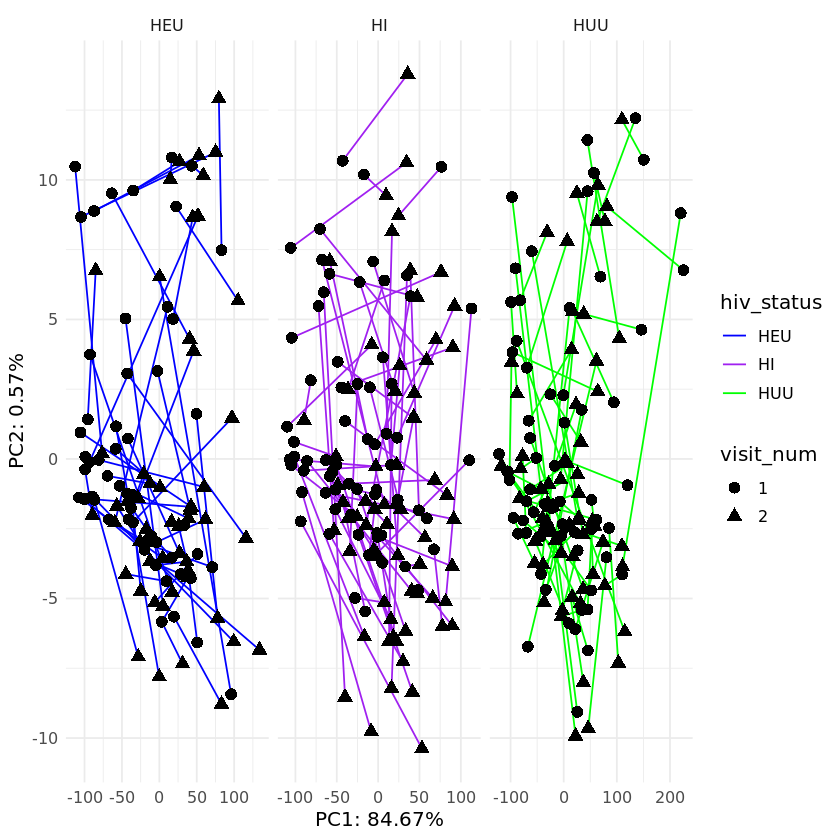

In [26]:
# now can plot the first two components of the PCA
pdf("img/volplot.pca.v1v2.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()

ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))

#### Seems to be a lot of overall volatility independent of source. Calculate volatility (here defined following *Bastiaanssen et al. 2020.*)

V2,count,mean,SD
<chr>,<int>,<dbl>,<dbl>
HEU,53,22.20564,3.808815
HI,61,22.22623,3.488947
HUU,64,23.13885,5.264253



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 1724, p-value = 0.2612
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HEU", ]$value
W = 1590, p-value = 0.8826
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HEU", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 1508.5, p-value = 0.3059
alternative hypothesis: true location shift is not equal to 0


png 
  2

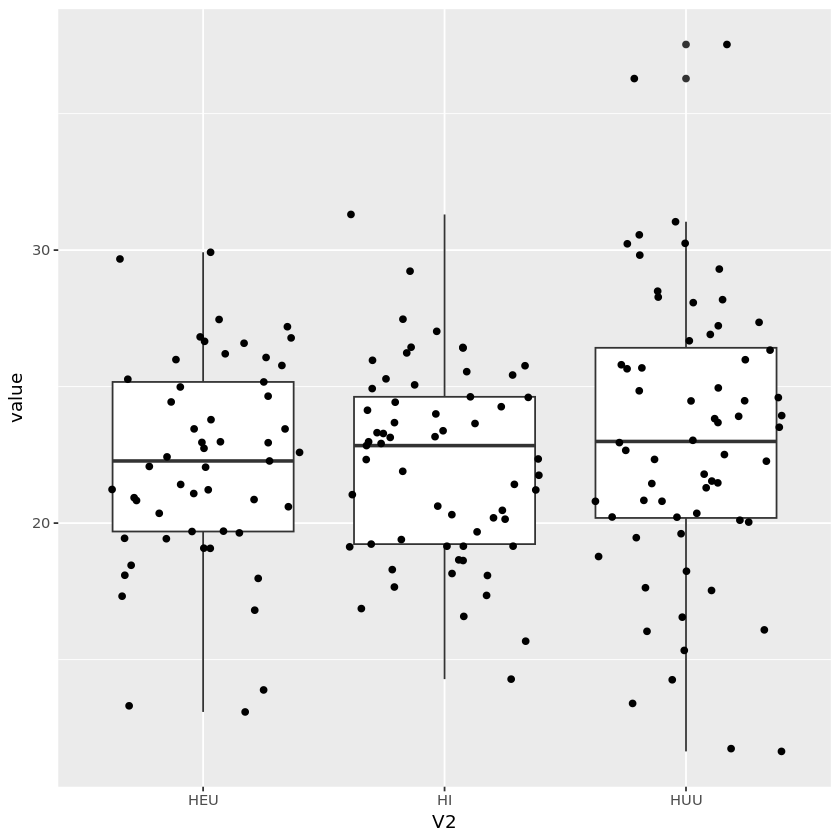

In [27]:
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v2$studyID_FDI, map.v1v2$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)

# boxplots
pdf("img/volatility.bplot.v1v2.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()

#### So no significant difference between each group in terms of the euclidean distance between visit one and visit two

### 3.2 Visit one versus visit three

In [28]:
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
dim(counts)
# remove asvs with zero count after filtering
counts <- counts[,colSums(counts) > 0]
dim(counts)

# make sure data is all numeric
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

[1]   408 14111

[1]   408 10945

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


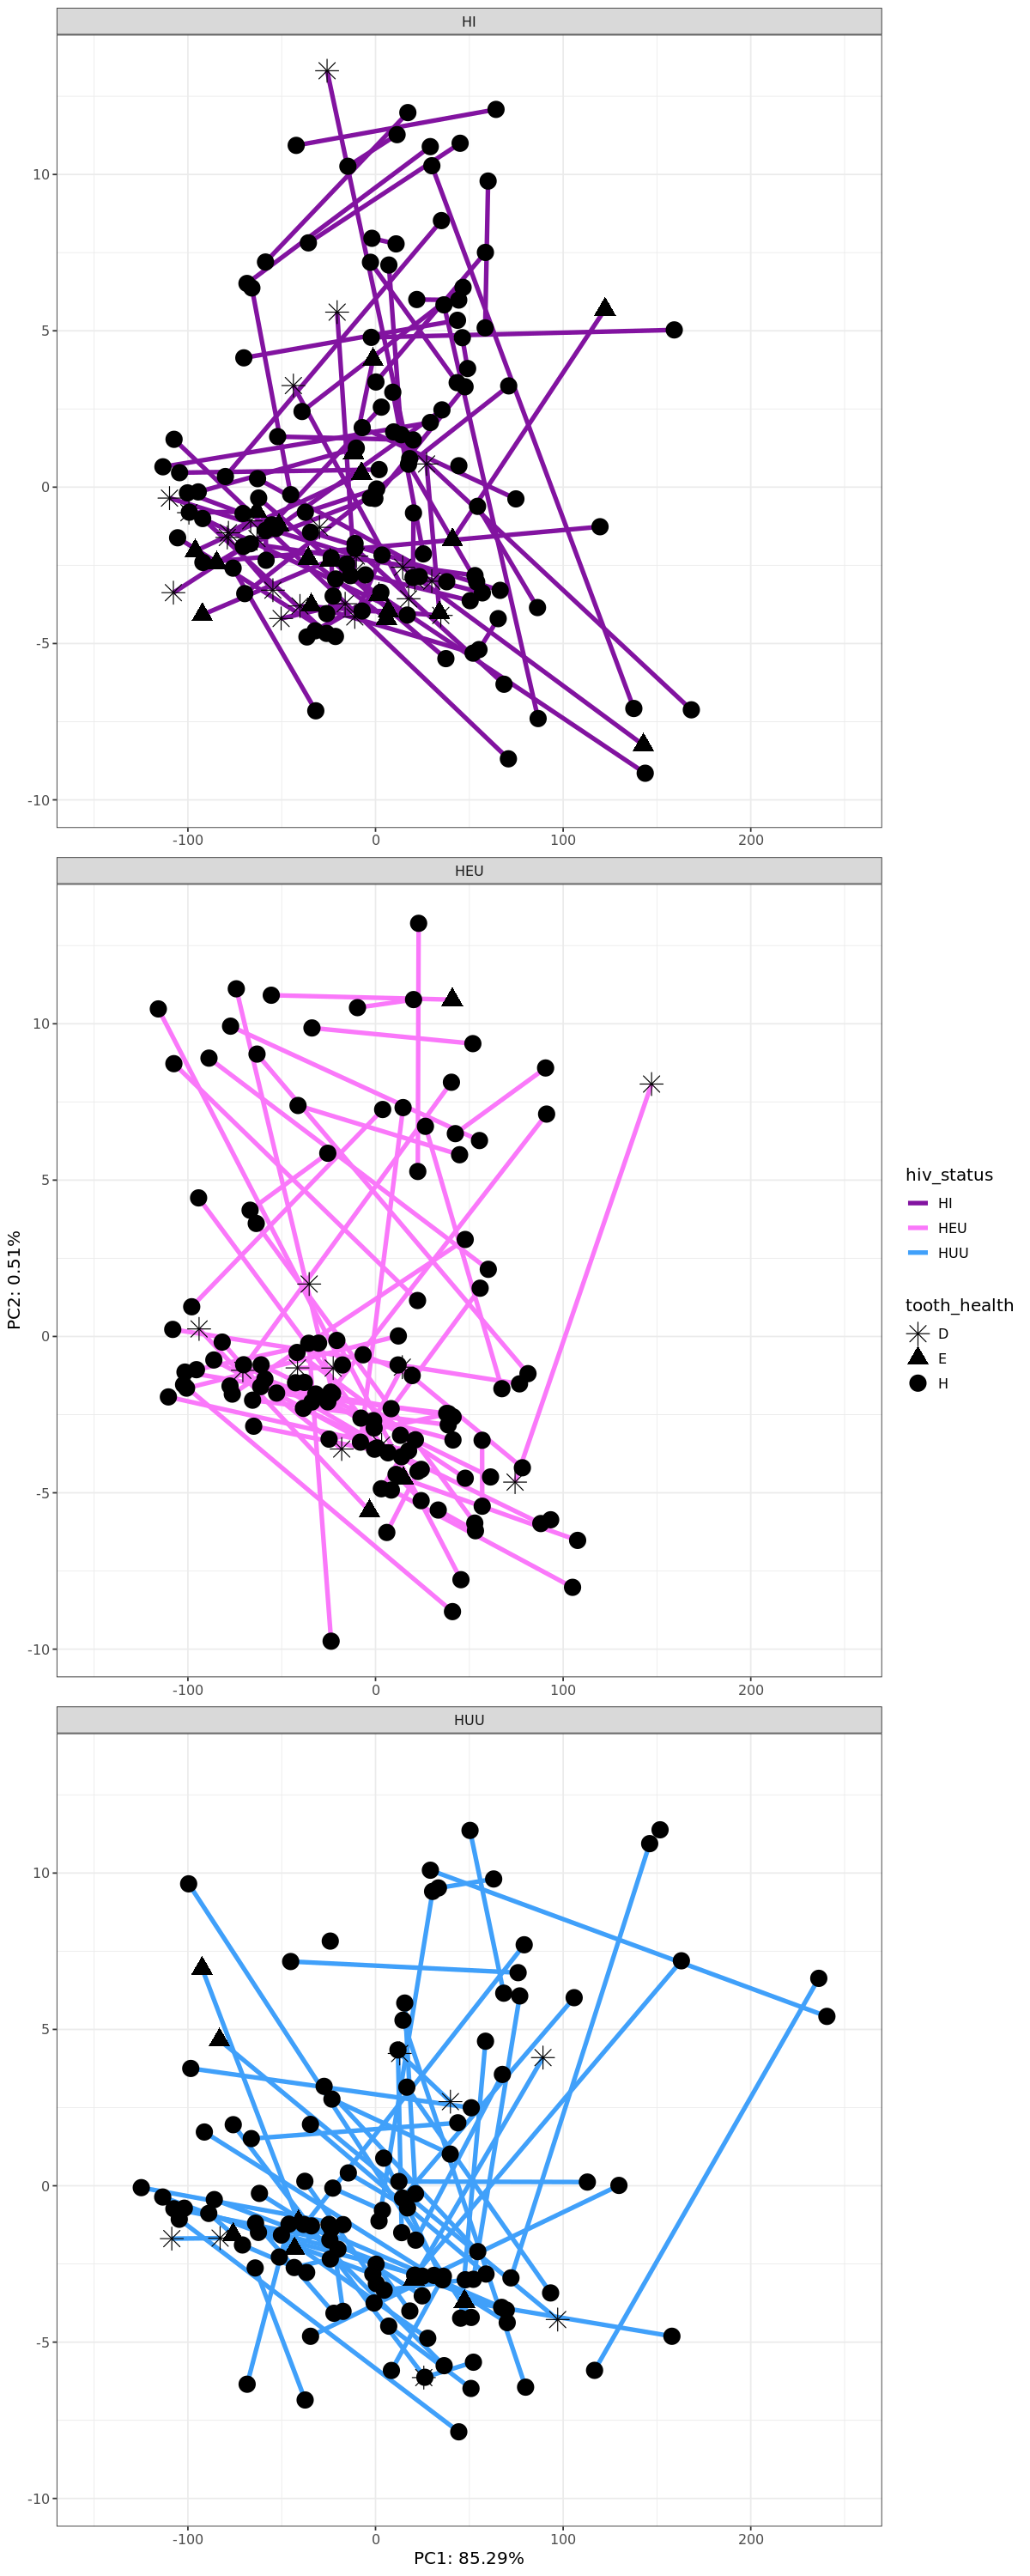

In [29]:
# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$hiv_status <- factor(pca$hiv_status, levels=c("HI", "HEU", "HUU"))
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

# spread out so we can see x axis more than 
options(repr.plot.width = 10, repr.plot.height =25)

# Plot!
pdf("img/volplot.pca.v1v3.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()

ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))

In [30]:
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE),
    min = min(value, na.rm = TRUE),
    max = max(value, na.rm = TRUE)
)

V2,count,mean,SD,min,max
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
HEU,59,22.31559,3.097594,17.30245,29.83731
HI,74,22.29336,4.259307,12.43078,32.49206
HUU,63,23.78060,4.919513,10.23758,36.96931


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


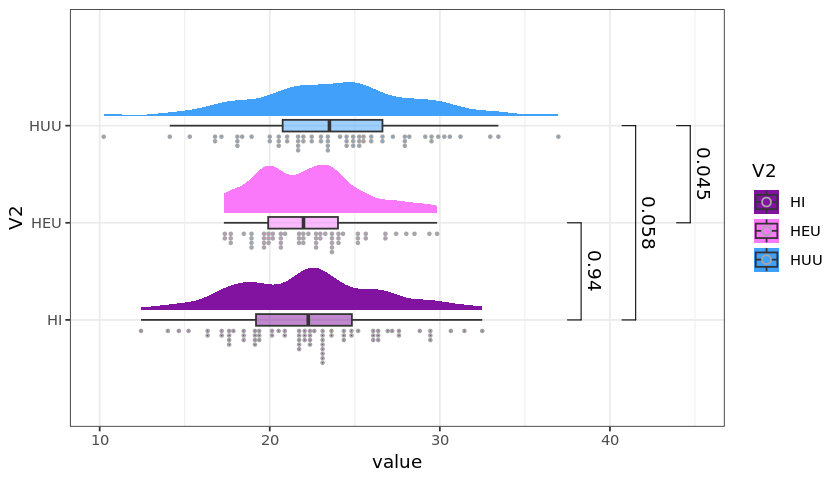

In [31]:
# boxplots
dist_diff$V2 <- factor(dist_diff$V2, levels=c("HI", "HEU", "HUU"))

pdf("img/volatility.bplot.v1v3.pdf")
options(repr.plot.width = 7, repr.plot.height =5)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()
dev.off()

options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.adj.format}", hide.ns =FALSE, method = "wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(10,45)) +
    coord_flip()

Just as a sanity check, are there major differences in age between these groups? Previously, we found that age was a major contributor to beta dispersal in HI kids

     hiv_status
age_y HEU HI HUU
   3    3  4   1
   4    5  9  15
   5   14 25   8
   6   22  9  13
   7   21 26  24
   8   22 44  22
   9   19 26  31
   10  16 17  11
   11   0  0   1

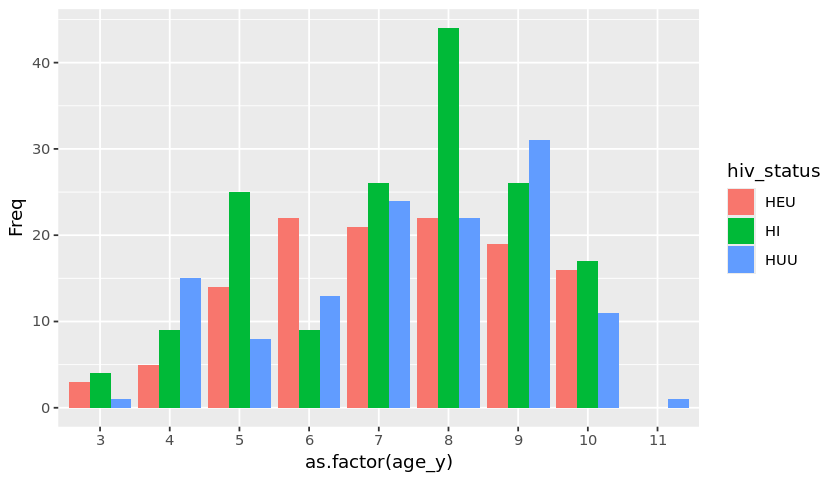

In [32]:
temp <- sample_data(ps.dat)[row.names(sample_data(ps.dat)) %in% row.names(map.v1v3),]
temp$age_y <- factor(temp$age_y, levels=c("3", "4", "5", "6", "7", "8", "9", "10", "11"))
with(temp, table(age_y, hiv_status))
# plot results
ggplot(as.data.frame(with(temp, table(age_y, hiv_status))), 
                                aes(as.factor(age_y), 
                                Freq, 
                                fill=hiv_status)) +
                                geom_col(position="dodge")

Look at the actual distribution by visit number 

[1] 7.471616

[1] 7.144828

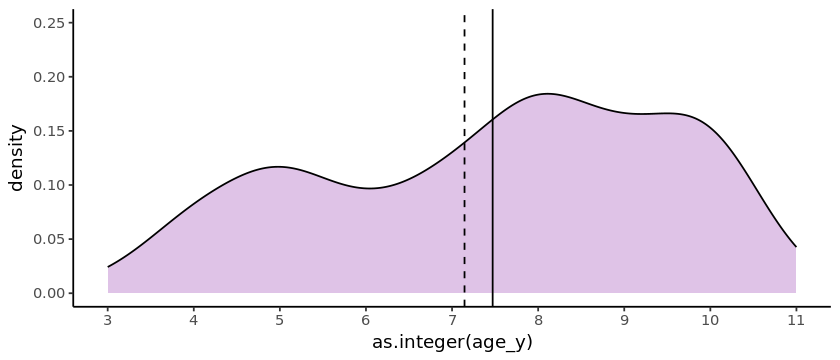

[1] 7.167513

[1] 6.724444

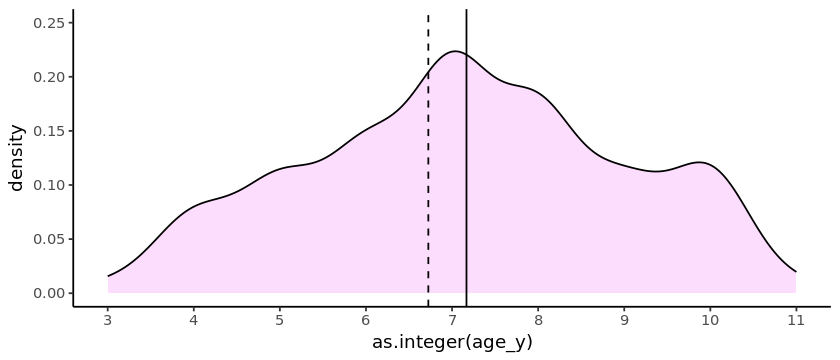

[1] 7

[1] 6.709957

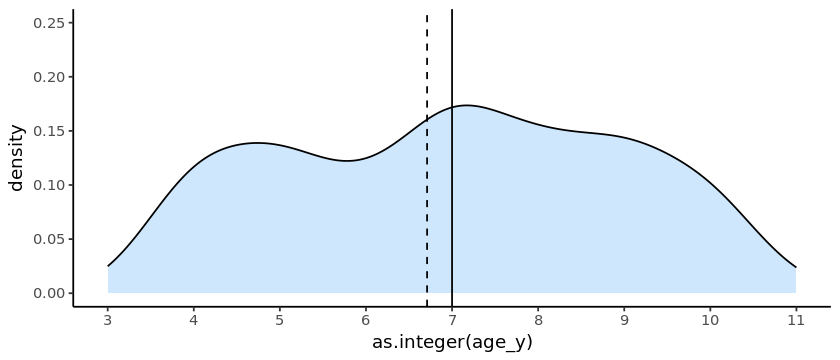

In [33]:
# comparing distribution of age between hiv groups in visit one and visit three
fullmap <- sample_data(ps.dat)
# set dimensions 
options(repr.plot.width = 7, repr.plot.height =3)

ggplot(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#8213A0", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))

mean(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3",]$age_y))
mean(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "1",]$age_y))

ggplot(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#FA78FA", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))

mean(as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3",]$age_y))
mean(as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "1",]$age_y))

ggplot(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#40A0FA", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))

mean(as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3",]$age_y))
mean(as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "1",]$age_y))

png 
  2

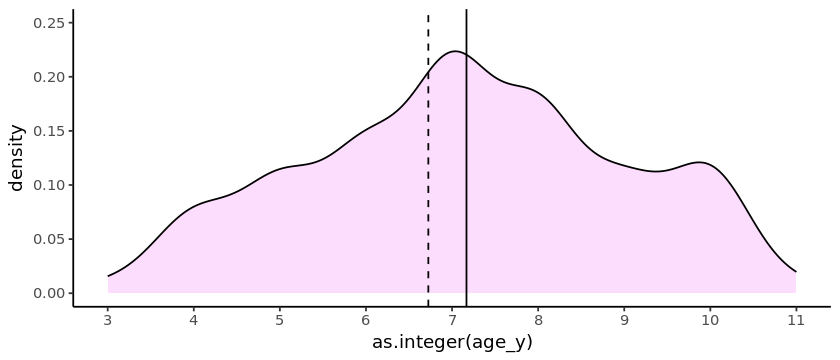

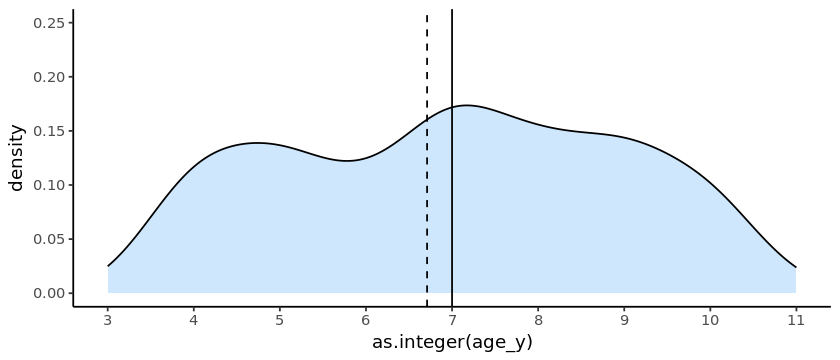

In [34]:
# save plots in single pdf
pdf("img/age_distribution_density_plots.HI.pdf")
ggplot(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#8213A0", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))
dev.off()

ggplot(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#FA78FA", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))
ggplot(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3",], aes(x=as.integer(age_y))) +
    geom_density(fill="#40A0FA", alpha=0.25) + 
    geom_vline(aes(xintercept=mean(as.integer(age_y)))) +
    geom_vline(aes(xintercept=mean(as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "1",]$age_y))), linetype="dashed") +
    theme_classic() +
    ylim(0.00, 0.25) +
    scale_x_continuous(limits=c(3,11), breaks=c(3,4,5,6,7,8,9,10,11))

In [35]:
# are there statistically significant differences in the age distribution (visit 3) that might affect volitility estimates?
wilcox.test(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3",]$age_y), as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3",]$age_y))
wilcox.test(as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3",]$age_y), as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3",]$age_y))
wilcox.test(as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3",]$age_y), as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3",]$age_y))


	Wilcoxon rank sum test with continuity correction

data:  as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3", ]$age_y) and as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3", ]$age_y)
W = 24937, p-value = 0.05739
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  as.integer(fullmap[fullmap$hiv_status == "HI" & fullmap$visit_num == "3", ]$age_y) and as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3", ]$age_y)
W = 25102, p-value = 0.01126
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  as.integer(fullmap[fullmap$hiv_status == "HEU" & fullmap$visit_num == "3", ]$age_y) and as.integer(fullmap[fullmap$hiv_status == "HUU" & fullmap$visit_num == "3", ]$age_y)
W = 19772, p-value = 0.4325
alternative hypothesis: true location shift is not equal to 0


### 3.3 Also check visit two to visit three 

this should be very similar to visit one versus visit two if time is really driving these patterns

[1]   510 14111

[1]   510 11678

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


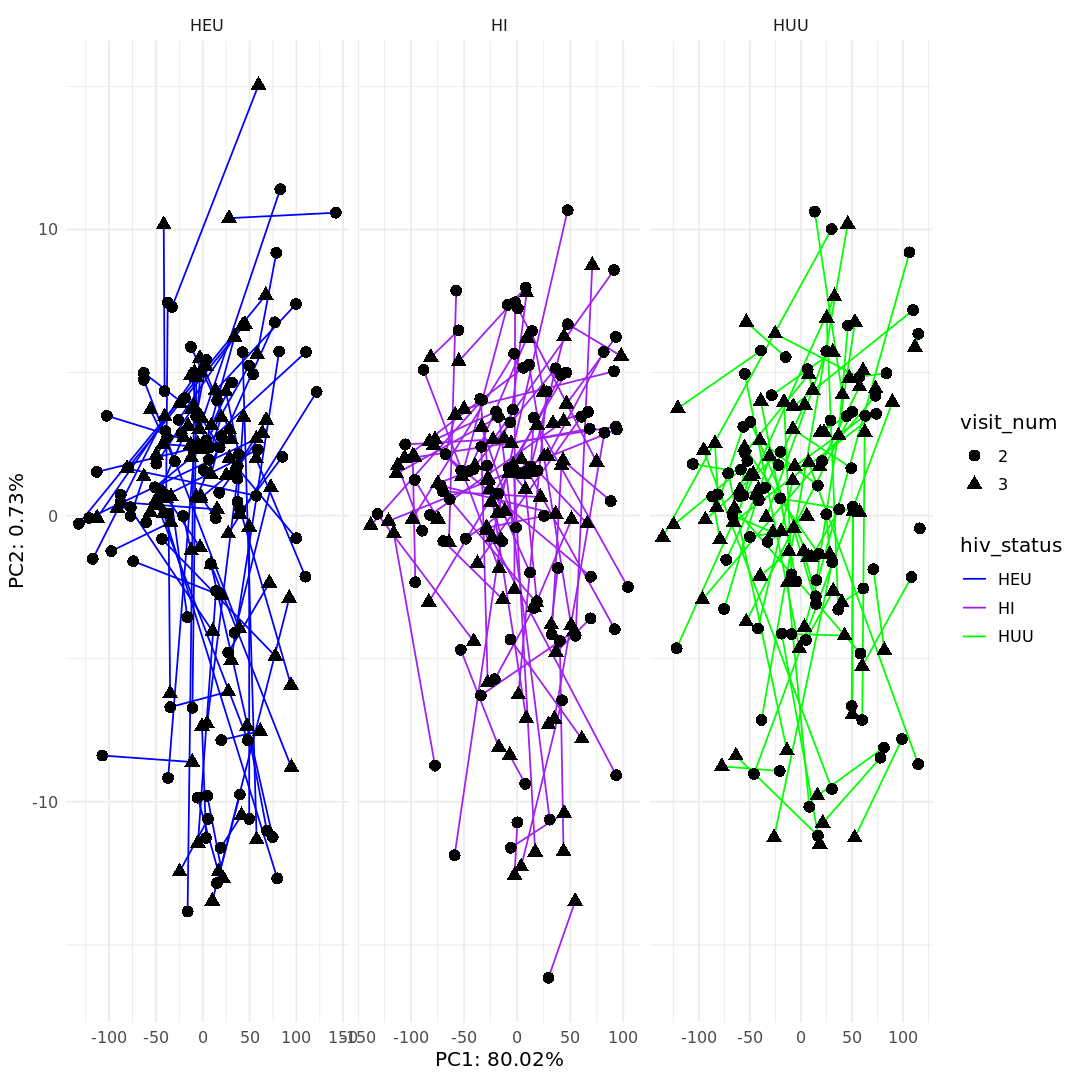

In [36]:
counts <- otu_table(ps.dat)[row.names(map.v2v3),]
dim(counts)
# remove asvs with zero count after filtering
counts <- counts[,colSums(counts) > 0]
dim(counts)

# reset figure options
# set dimensions 
options(repr.plot.width = 9, repr.plot.height =9)

# make sure data is all numeric
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v2v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v2v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v2v3$tooth_health # treatment
pca$visit_num <- map.v2v3$visit_num # time point data

# now can plot the first two components of the PCA
pdf("img/volplot.pca.v2v3.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))

V2,count,mean,SD
<chr>,<int>,<dbl>,<dbl>
HEU,92,23.95174,3.108972
HI,87,23.19323,3.682214
HUU,80,23.56597,3.943205



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 3324.5, p-value = 0.6195
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HEU", ]$value
W = 3644.5, p-value = 0.3029
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HEU", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 3839, p-value = 0.6266
alternative hypothesis: true location shift is not equal to 0


png 
  2

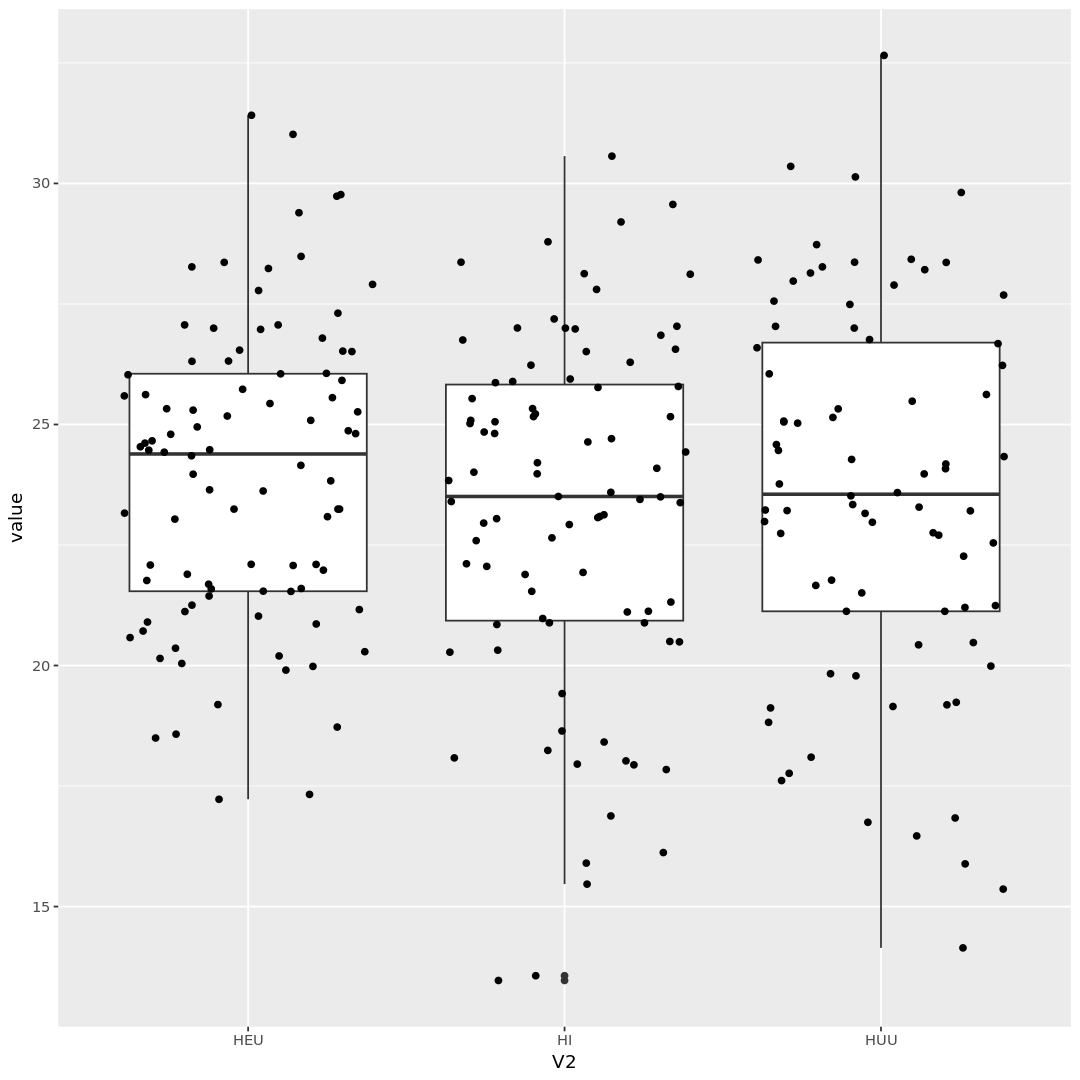

In [37]:
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v2v3$studyID_FDI, map.v2v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)

# boxplots
pdf("img/volatility.bplot.v2v3.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()

### 3.4 What about with only healthy teeth?

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,median,SD
<chr>,<int>,<dbl>,<dbl>
HEU,52,22.45735,3.056431
HI,53,22.27747,3.908752
HUU,54,23.46366,4.522158


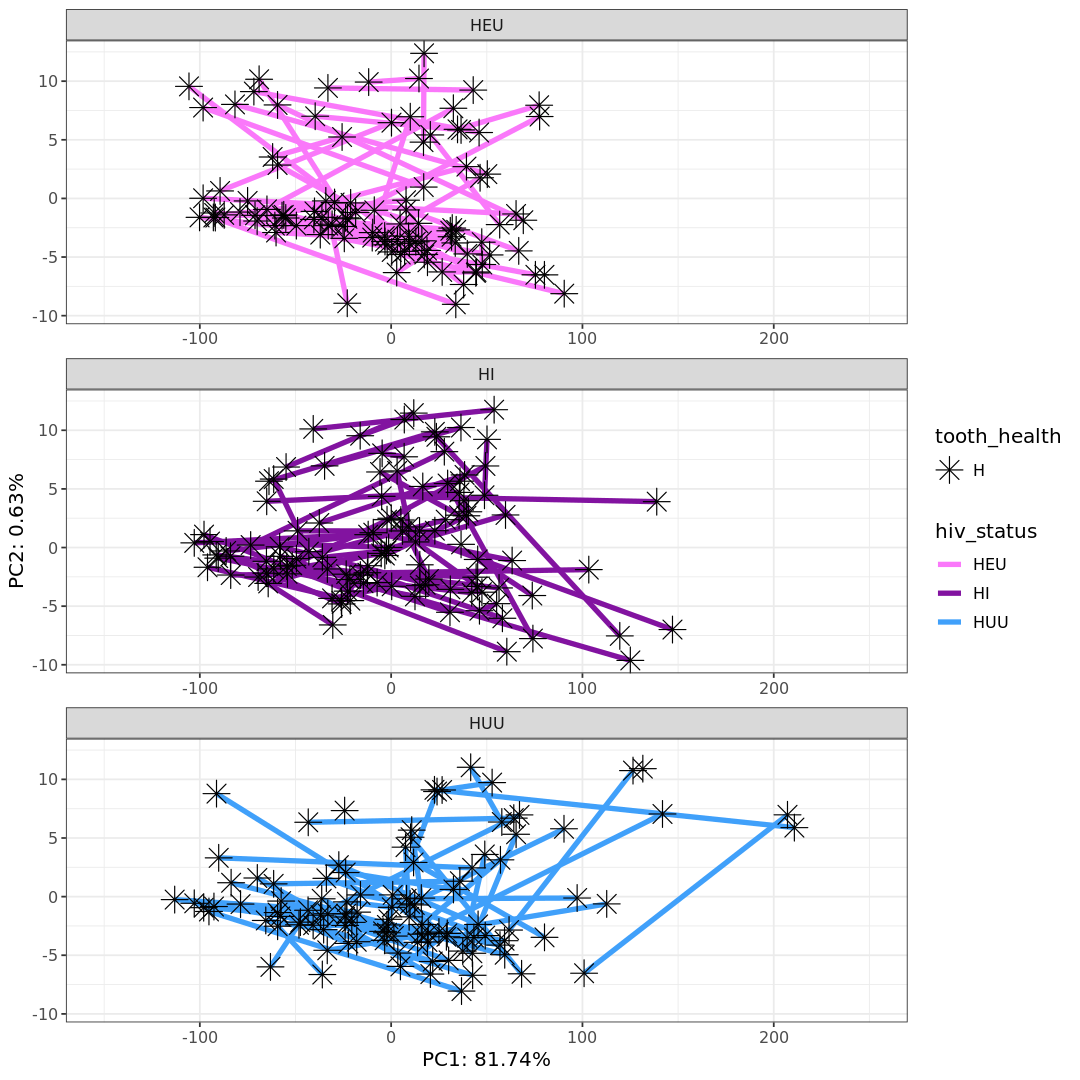

In [38]:
# first filter so that we are only looking at healthy teeth in our phyloseq object
ps.dat.h <- subset_samples(ps.dat, tooth_health=="H")
# pull metadata table
map <- sample_data(ps.dat.h)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.H.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    median = median(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


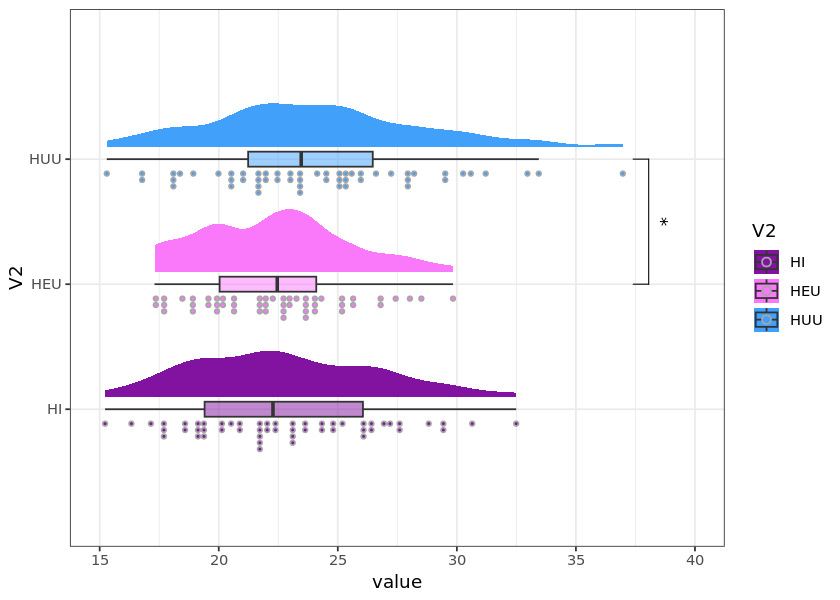

In [39]:
# boxplots
dist_diff$V2 <- factor(dist_diff$V2, levels=c("HI", "HEU", "HUU"))

pdf("img/volatility.bplot.v1v3.H.pdf")
options(repr.plot.width = 7, repr.plot.height =5)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.signif}", hide.ns = TRUE, method="wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    coord_flip()
dev.off()

options(repr.plot.width = 7, repr.plot.height =5)
ggplot(dist_diff, aes(x=V2, y=value, fill=V2)) + 
    geom_pwc(label = "{p.signif}", hide.ns = TRUE, method="wilcox_test", p.adjust.method = "none") +
    theme_bw() +
    stat_halfeye(adjust = 0.5, justification = -0.2, .width = 0, point_colour = NA, normalize="all", scale=0.5) + 
    geom_boxplot(width = 0.12, alpha = 0.5, outlier.color=NA) +
    stat_dots(side = "left", justification = 1.1, binwidth = 0.25) +
    scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
    scale_y_continuous(limits=c(15,40)) +
    coord_flip()

### 3.5 Diseased teeth only?

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,mean,IQR
<chr>,<int>,<dbl>,<dbl>
HEU,2,20.33132,0.5486333
HI,8,19.06724,5.8783510
HUU,2,17.43915,7.2015629



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 9, p-value = 0.8889
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HEU", ]$value
W = 6, p-value = 0.7111
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HEU", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 2, p-value = 1
alternative hypothesis: true location shift is not equal to 0


png 
  2

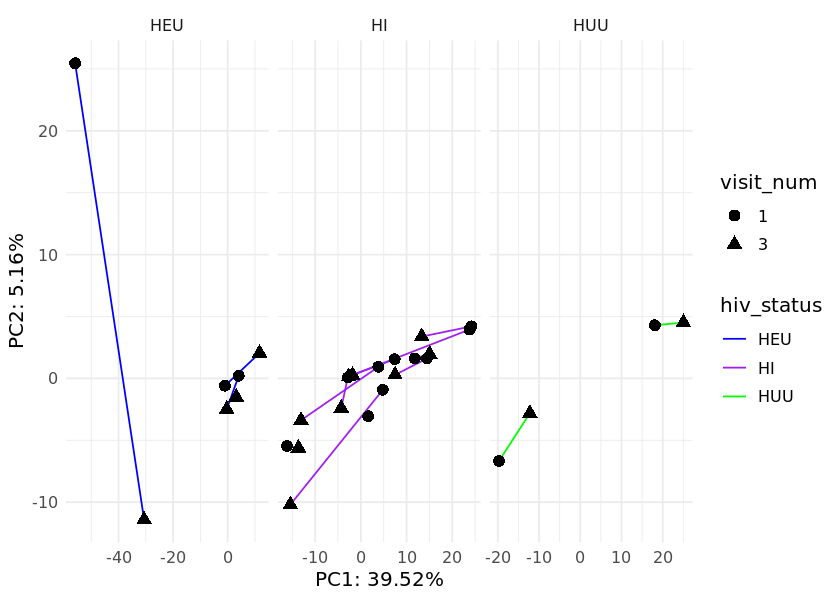

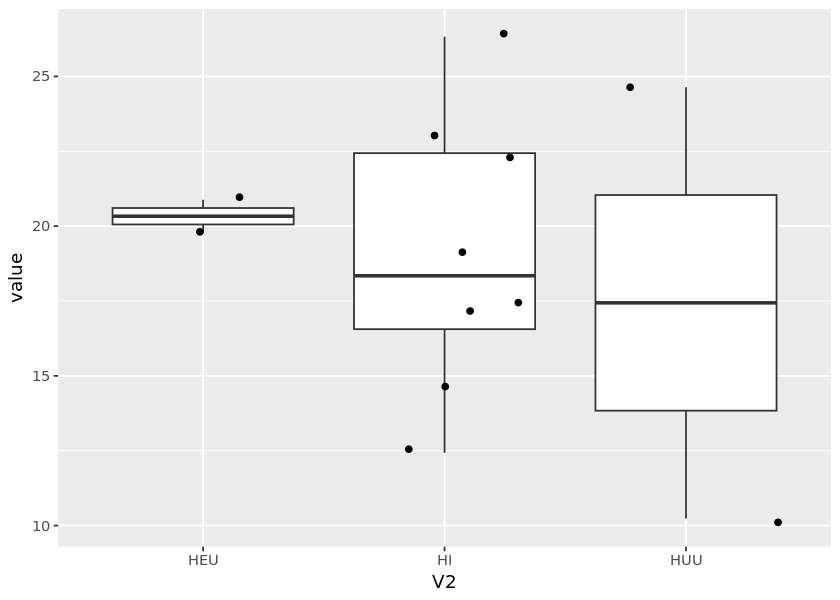

In [40]:
# first filter so that we are only looking at healthy teeth in our phyloseq object
ps.dat.d <- subset_samples(ps.dat, tooth_health=="D")
# pull metadata table
map <- sample_data(ps.dat.d)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.D.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    IQR = IQR(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
                
# boxplots
pdf("img/volatility.bplot.v1v3.D.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter() 

Not enough samples to make any inteferences. Will probably be the same for enamel cavities

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,mean,IQR
<chr>,<int>,<dbl>,<dbl>
HI,6,21.02418,4.565156
HUU,1,17.15962,0.000000



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 5, p-value = 0.5714
alternative hypothesis: true location shift is not equal to 0


png 
  2

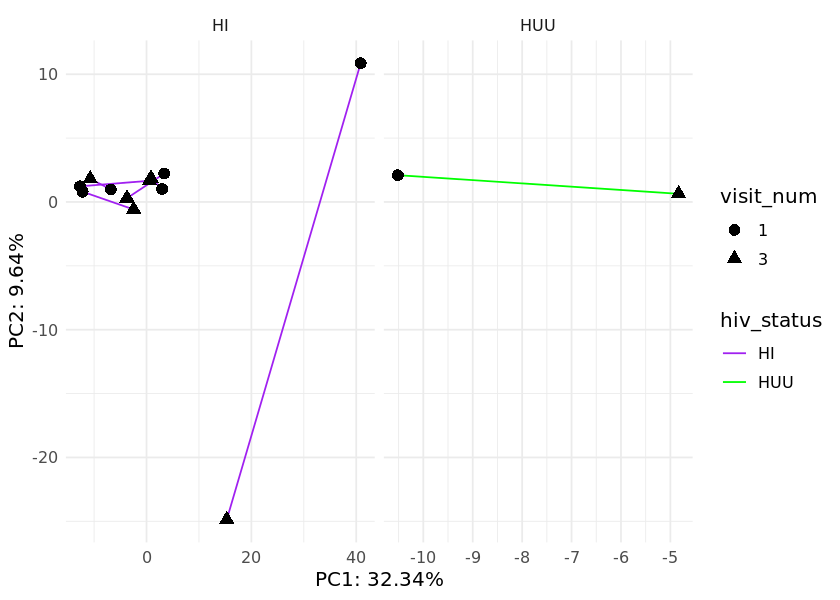

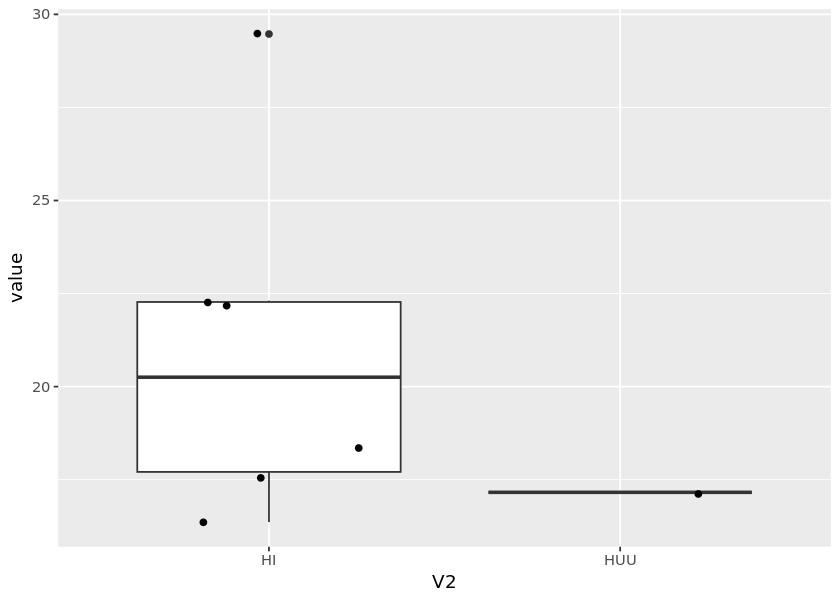

In [41]:
# first filter so that we are only looking at healthy teeth in our phyloseq object
ps.dat.e <- subset_samples(ps.dat, tooth_health=="E")
# pull metadata table
map <- sample_data(ps.dat.e)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.E.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    IQR = IQR(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
# wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
# wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
                
# boxplots
pdf("img/volatility.bplot.v1v3.E.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter() 

Same, not enough samples

A couple other categories to investigate -- what about difference between "totally healthy" teeth? And those teeth in a mouth with cavities that is otherwise healthy?

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,median,SD
<chr>,<int>,<dbl>,<dbl>
HEU,3,19.78269,0.6428477
HI,16,18.74483,5.4306967
HUU,5,24.64071,7.4885668


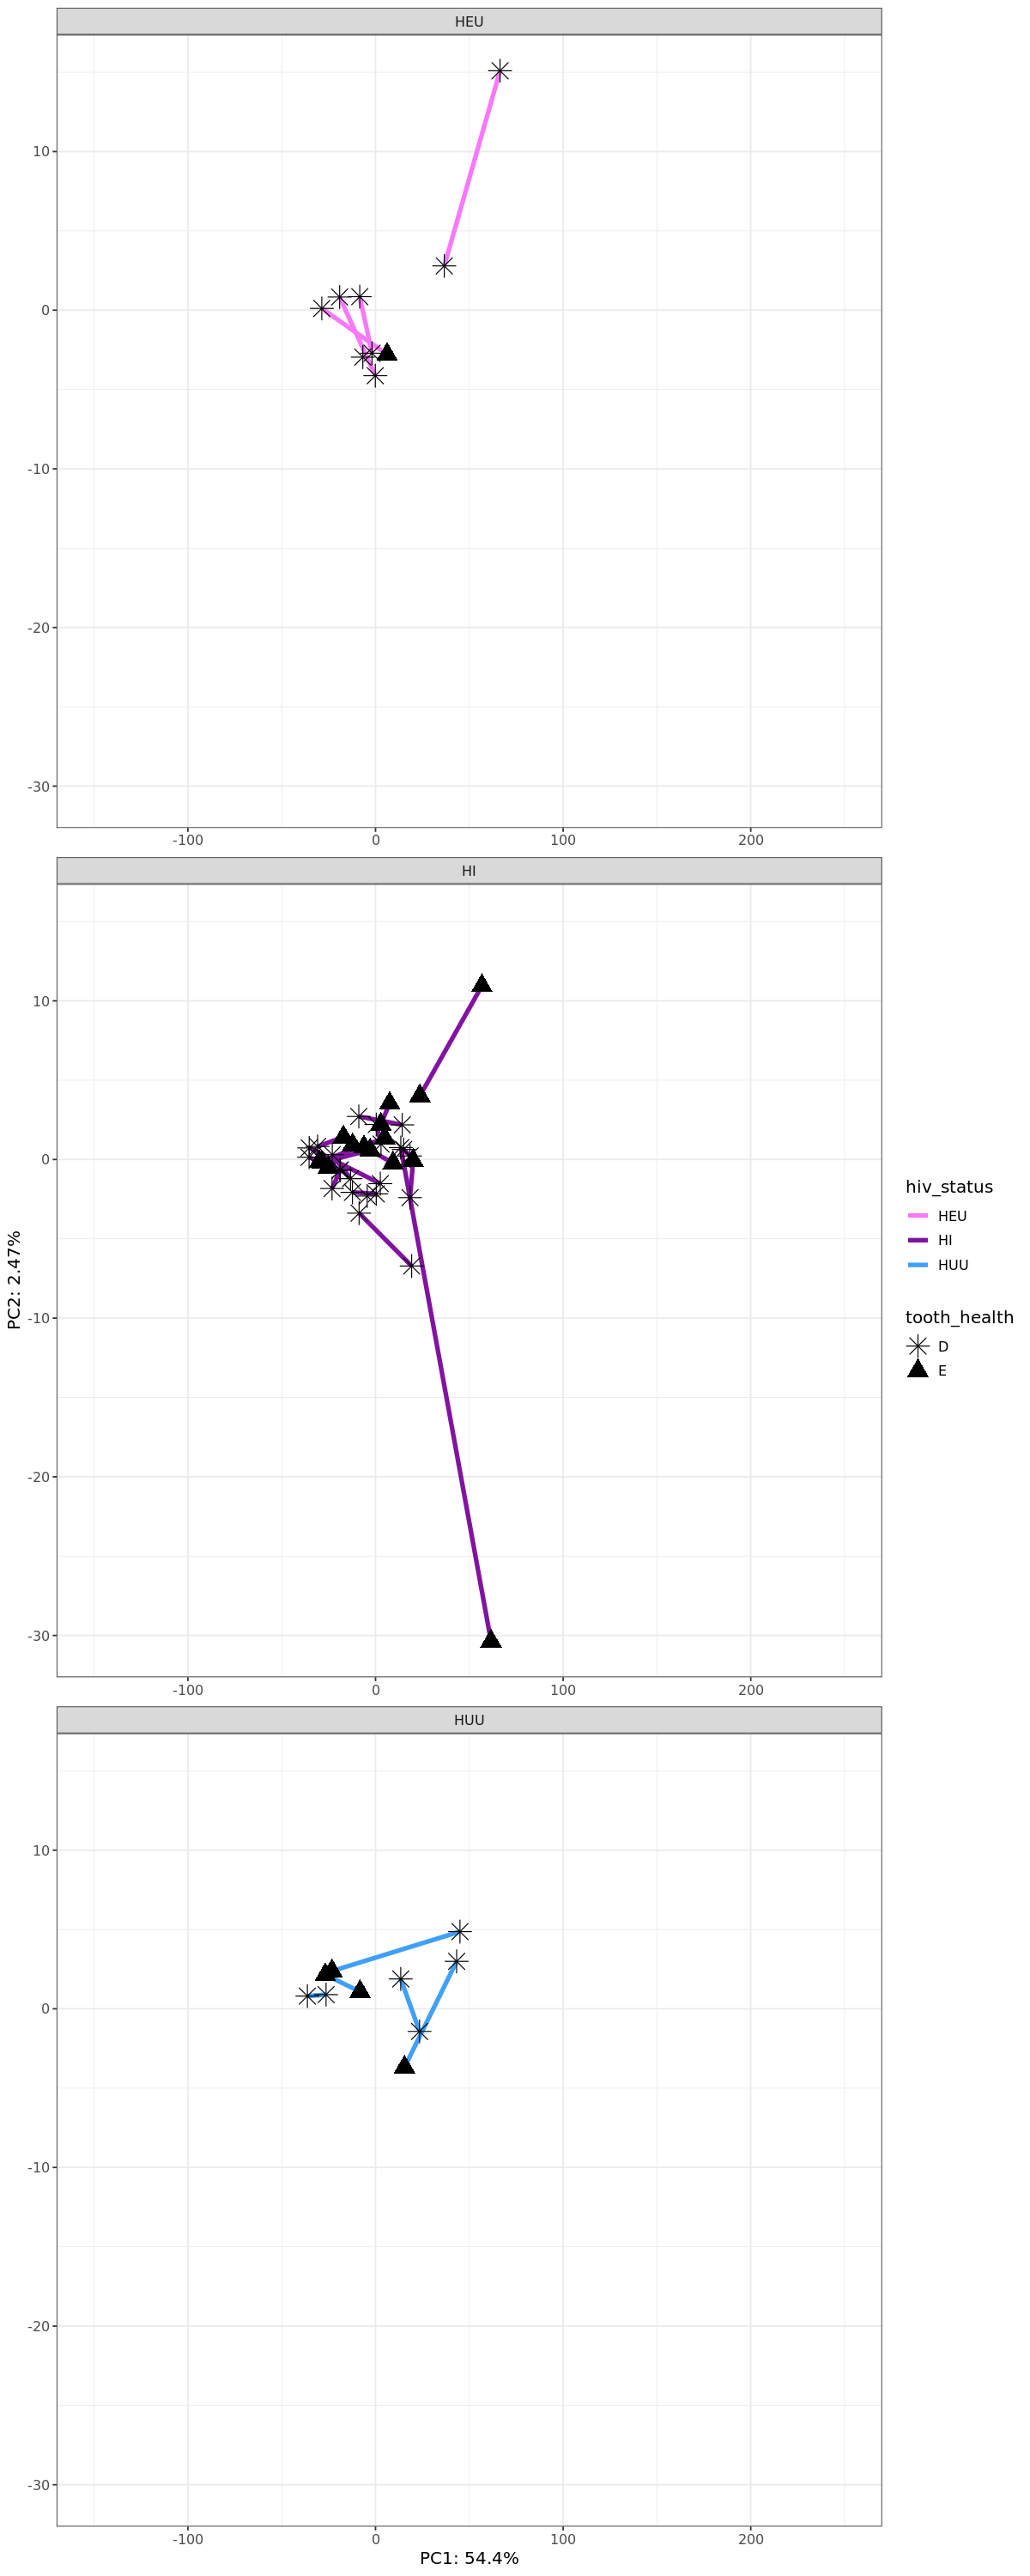

In [42]:
# what about teeth that are either D or E?
# first filter so that we are only looking at healthy teeth in our phyloseq object
ps.dat.ca <- subset_samples(ps.dat, tooth_health!="H")
# pull metadata table
map <- sample_data(ps.dat.ca)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

# spread out so we can see x axis more than 
options(repr.plot.width = 10, repr.plot.height =25)
                
pdf("img/volplot.pca.v1v3.ED.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = tooth_health,
                group = studyID_FDI)) +  
geom_line(lwd=1.5) +
geom_point(size = 5, col="black") +
scale_shape_manual(values=c(8,17,19)) +
facet_wrap(~hiv_status, scales = "free_x", ncol=1) +
scale_fill_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
scale_colour_manual(values=c("HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA")) +
theme_bw() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
xlim(-150,250) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    median = median(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

### 3.6 H-CF and other aliquot type categories 

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,mean,IQR
<chr>,<int>,<dbl>,<dbl>
HEU,44,22.62927,3.548269
HI,33,23.10823,6.999572
HUU,41,23.90660,5.474856


Warning message in wilcox.test.default(dist_diff[dist_diff$V2 == "HI", ]$value, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 605.5, p-value = 0.4433
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HEU", ]$value
W = 770, p-value = 0.6562
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(dist_diff[dist_diff$V2 == "HEU", ]$value, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  dist_diff[dist_diff$V2 == "HEU", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 748.5, p-value = 0.1784
alternative hypothesis: true location shift is not equal to 0


png 
  2

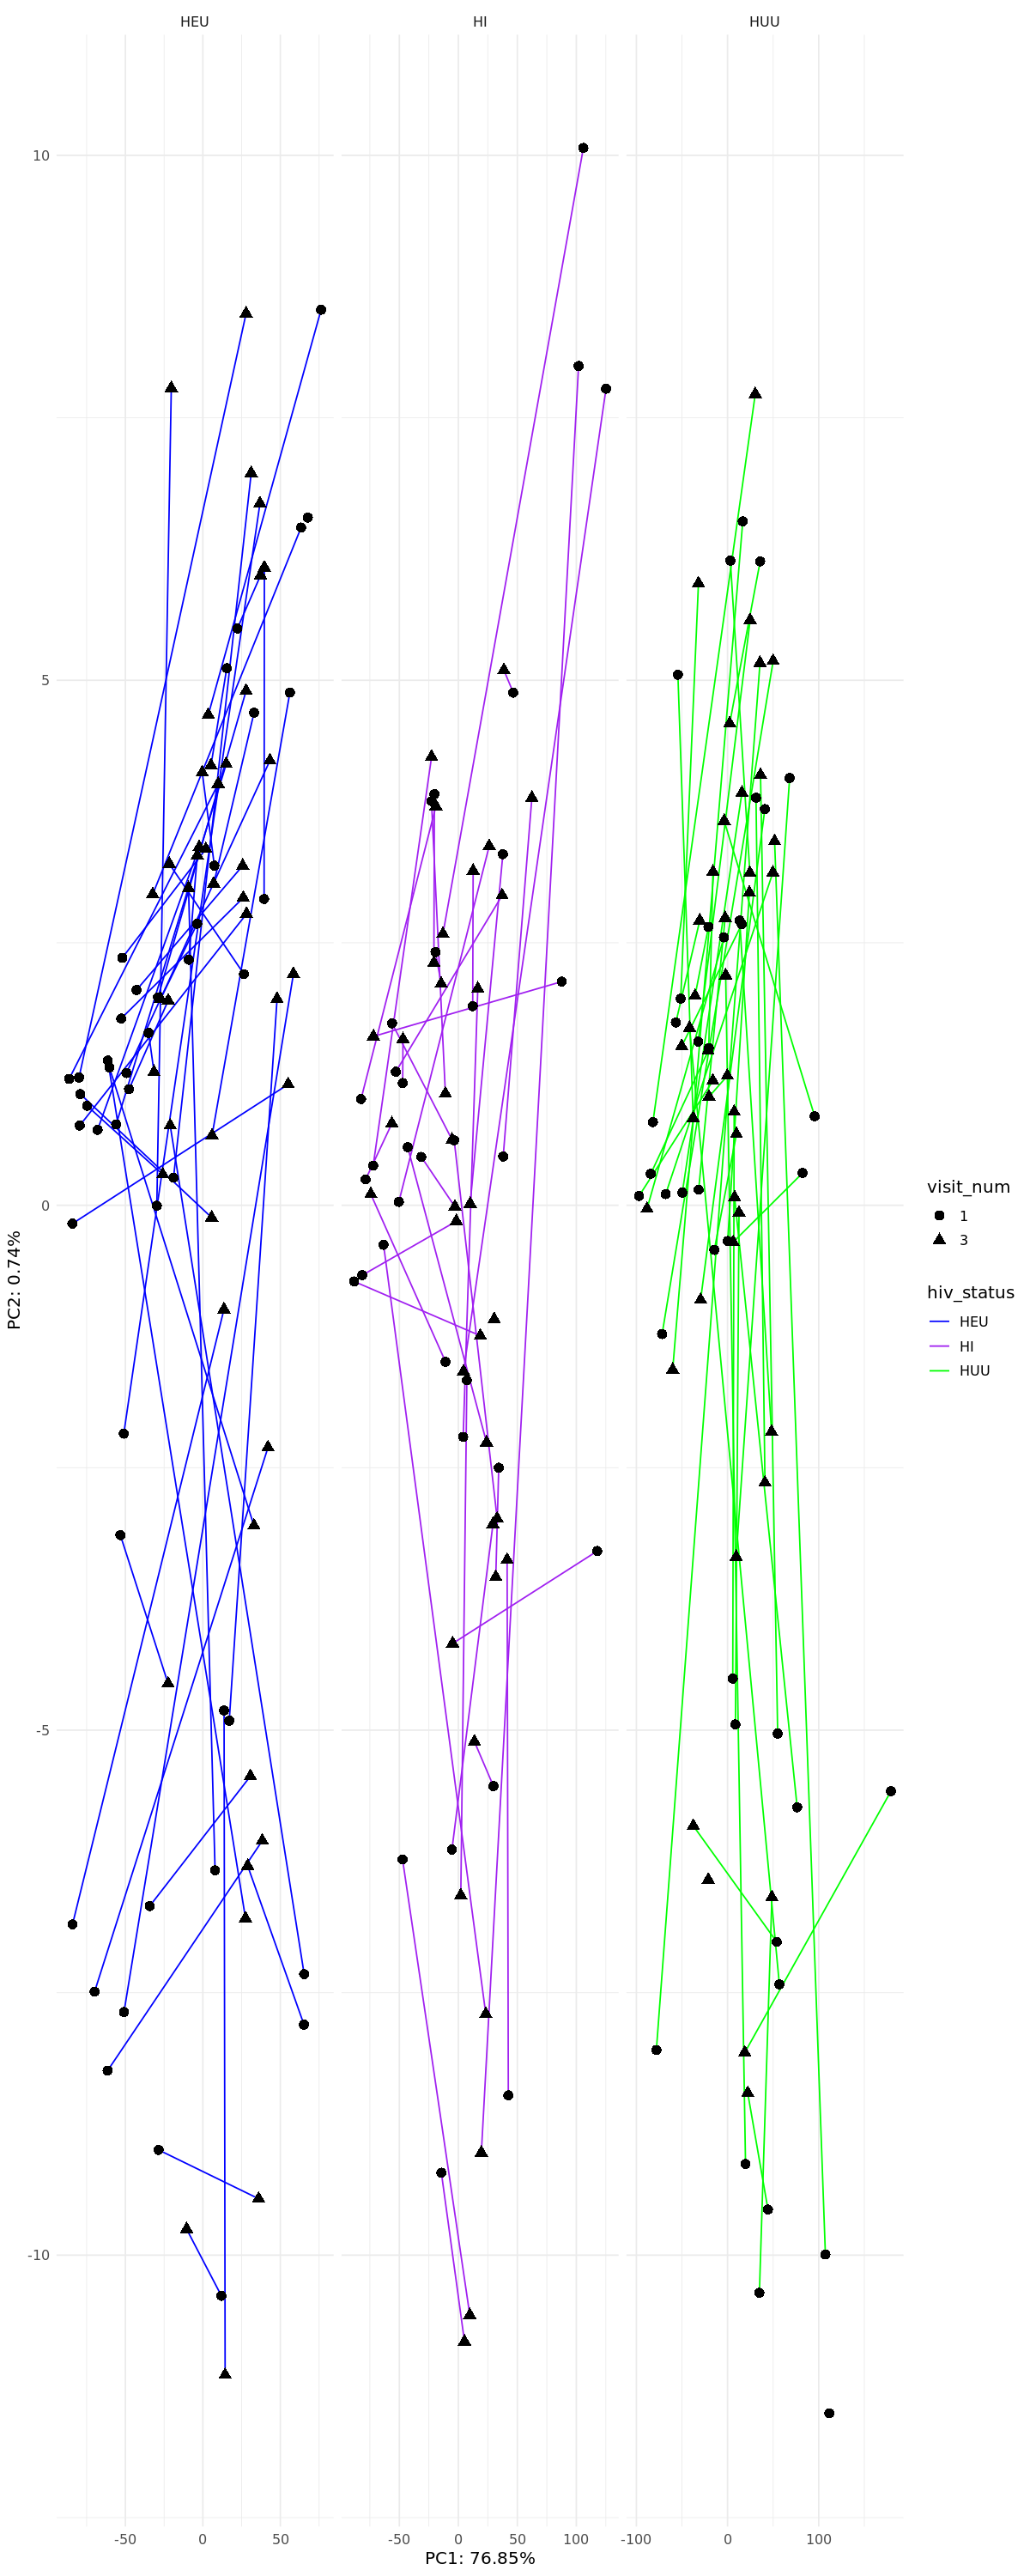

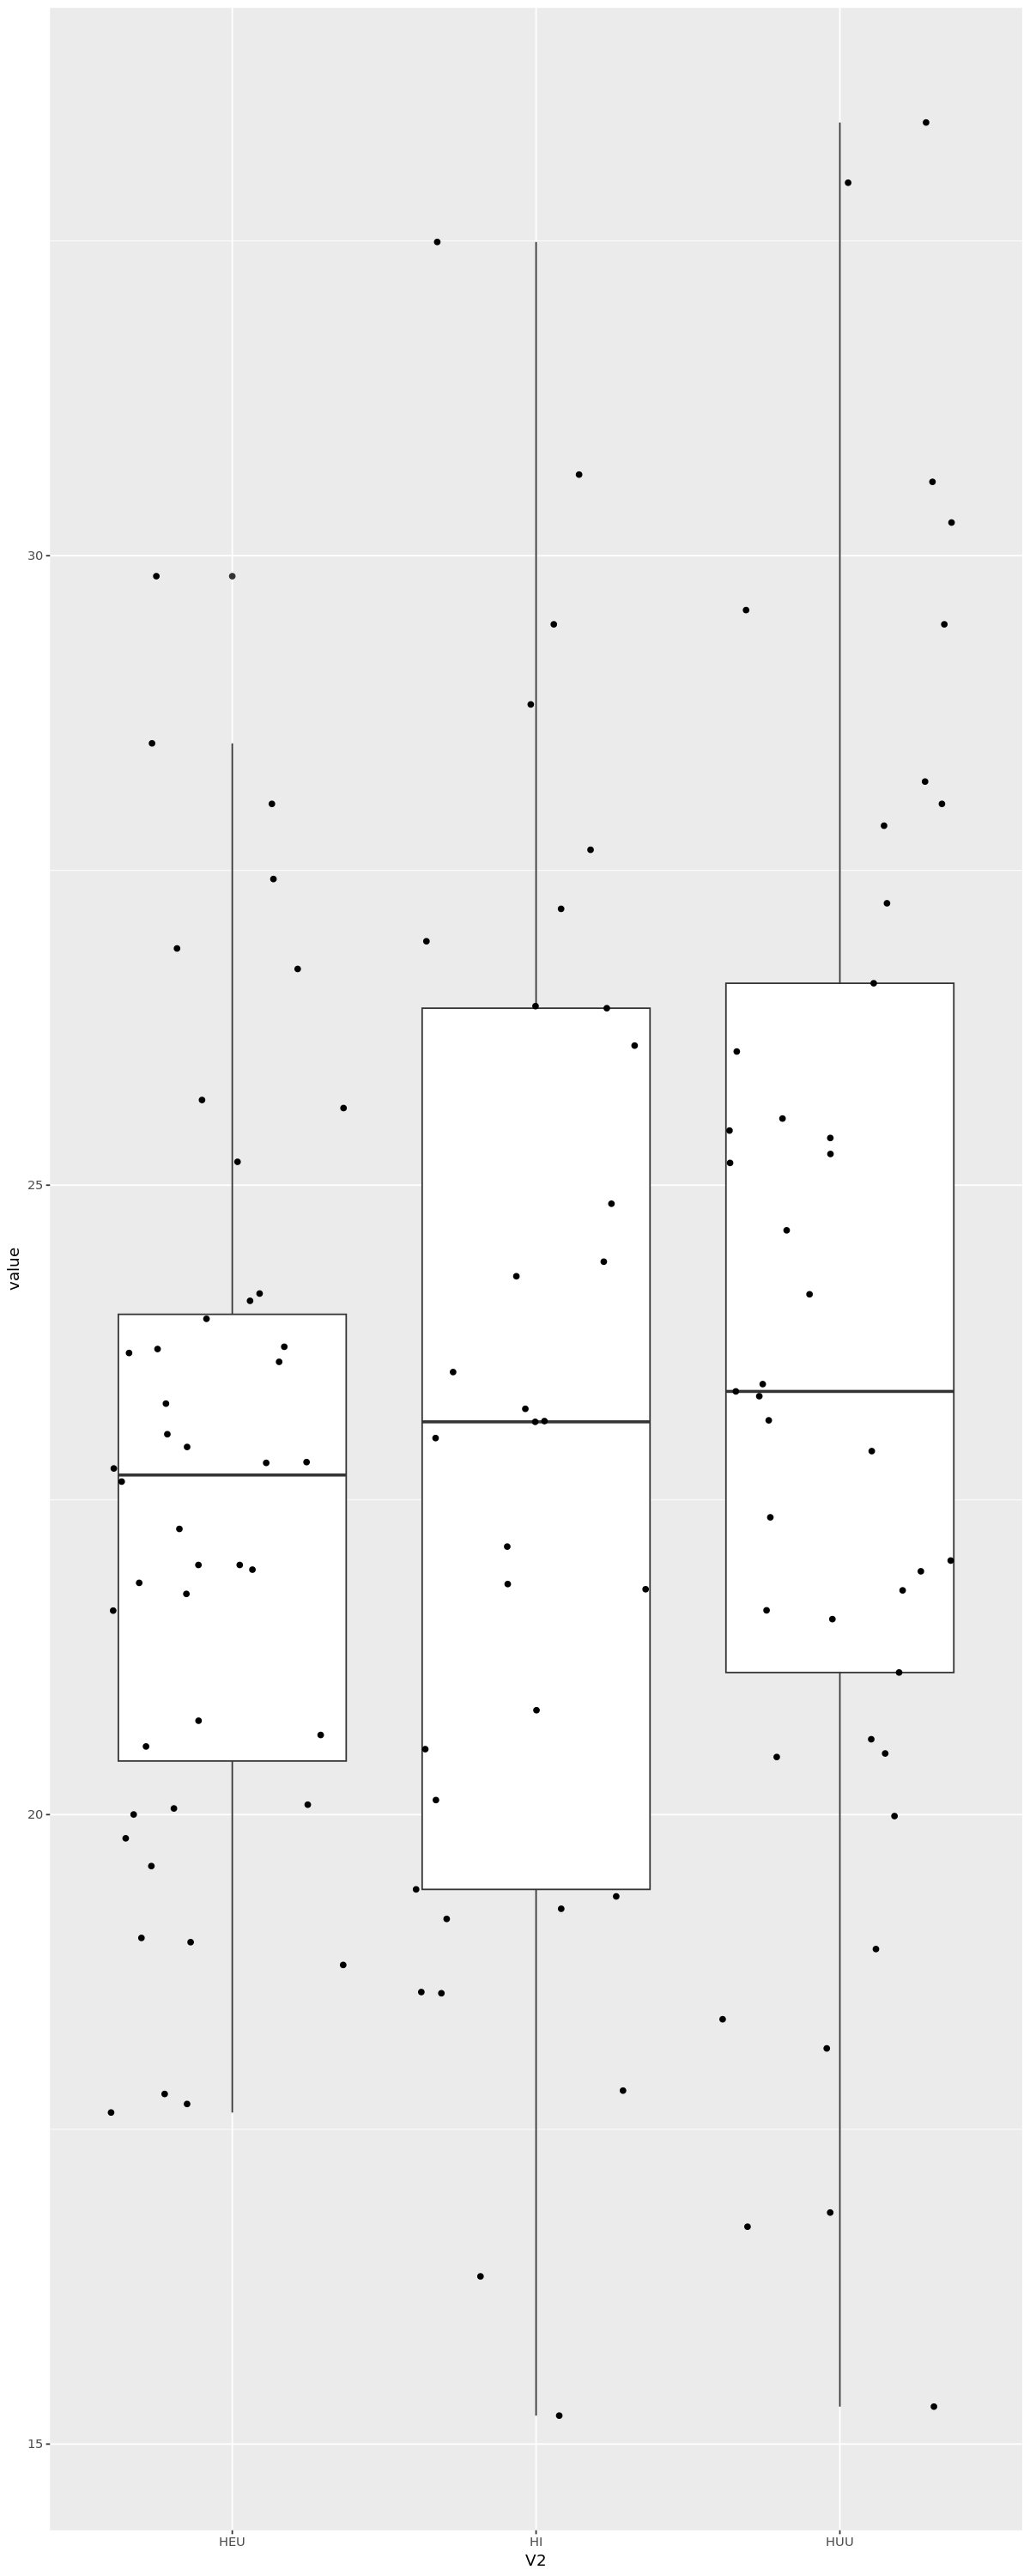

In [43]:
ps.dat.h <- subset_samples(ps.dat, aliquot_type=="H-CF")
# pull metadata table
map <- sample_data(ps.dat.h)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.HCF.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    IQR = IQR(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
                
# boxplots
pdf("img/volatility.bplot.v1v3.HCF.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()  

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,mean,IQR
<chr>,<int>,<dbl>,<dbl>
HEU,2,22.39945,2.857537
HUU,2,24.68862,1.181004


png 
  2

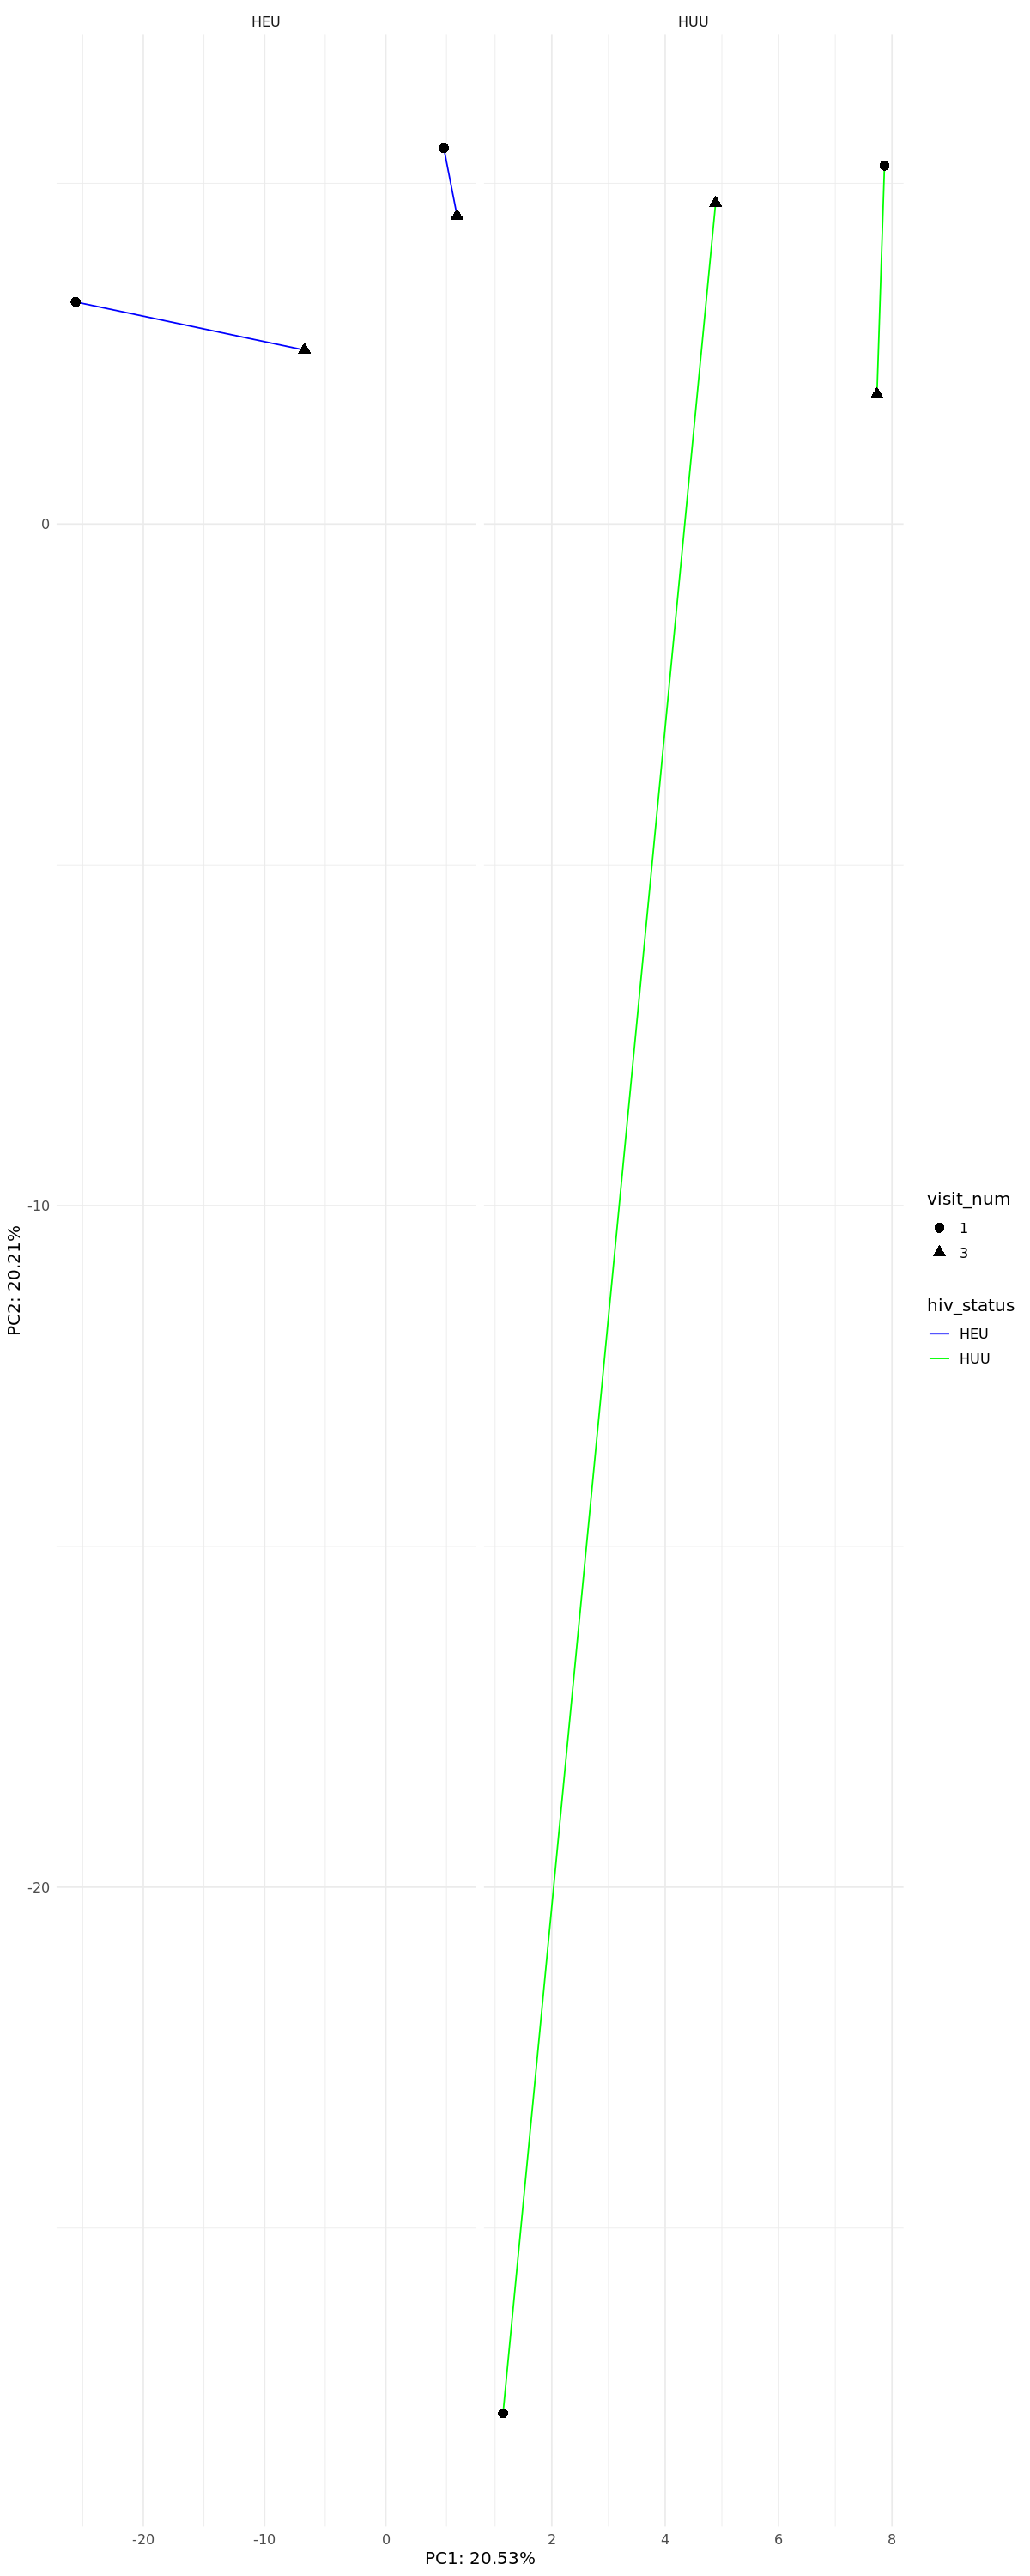

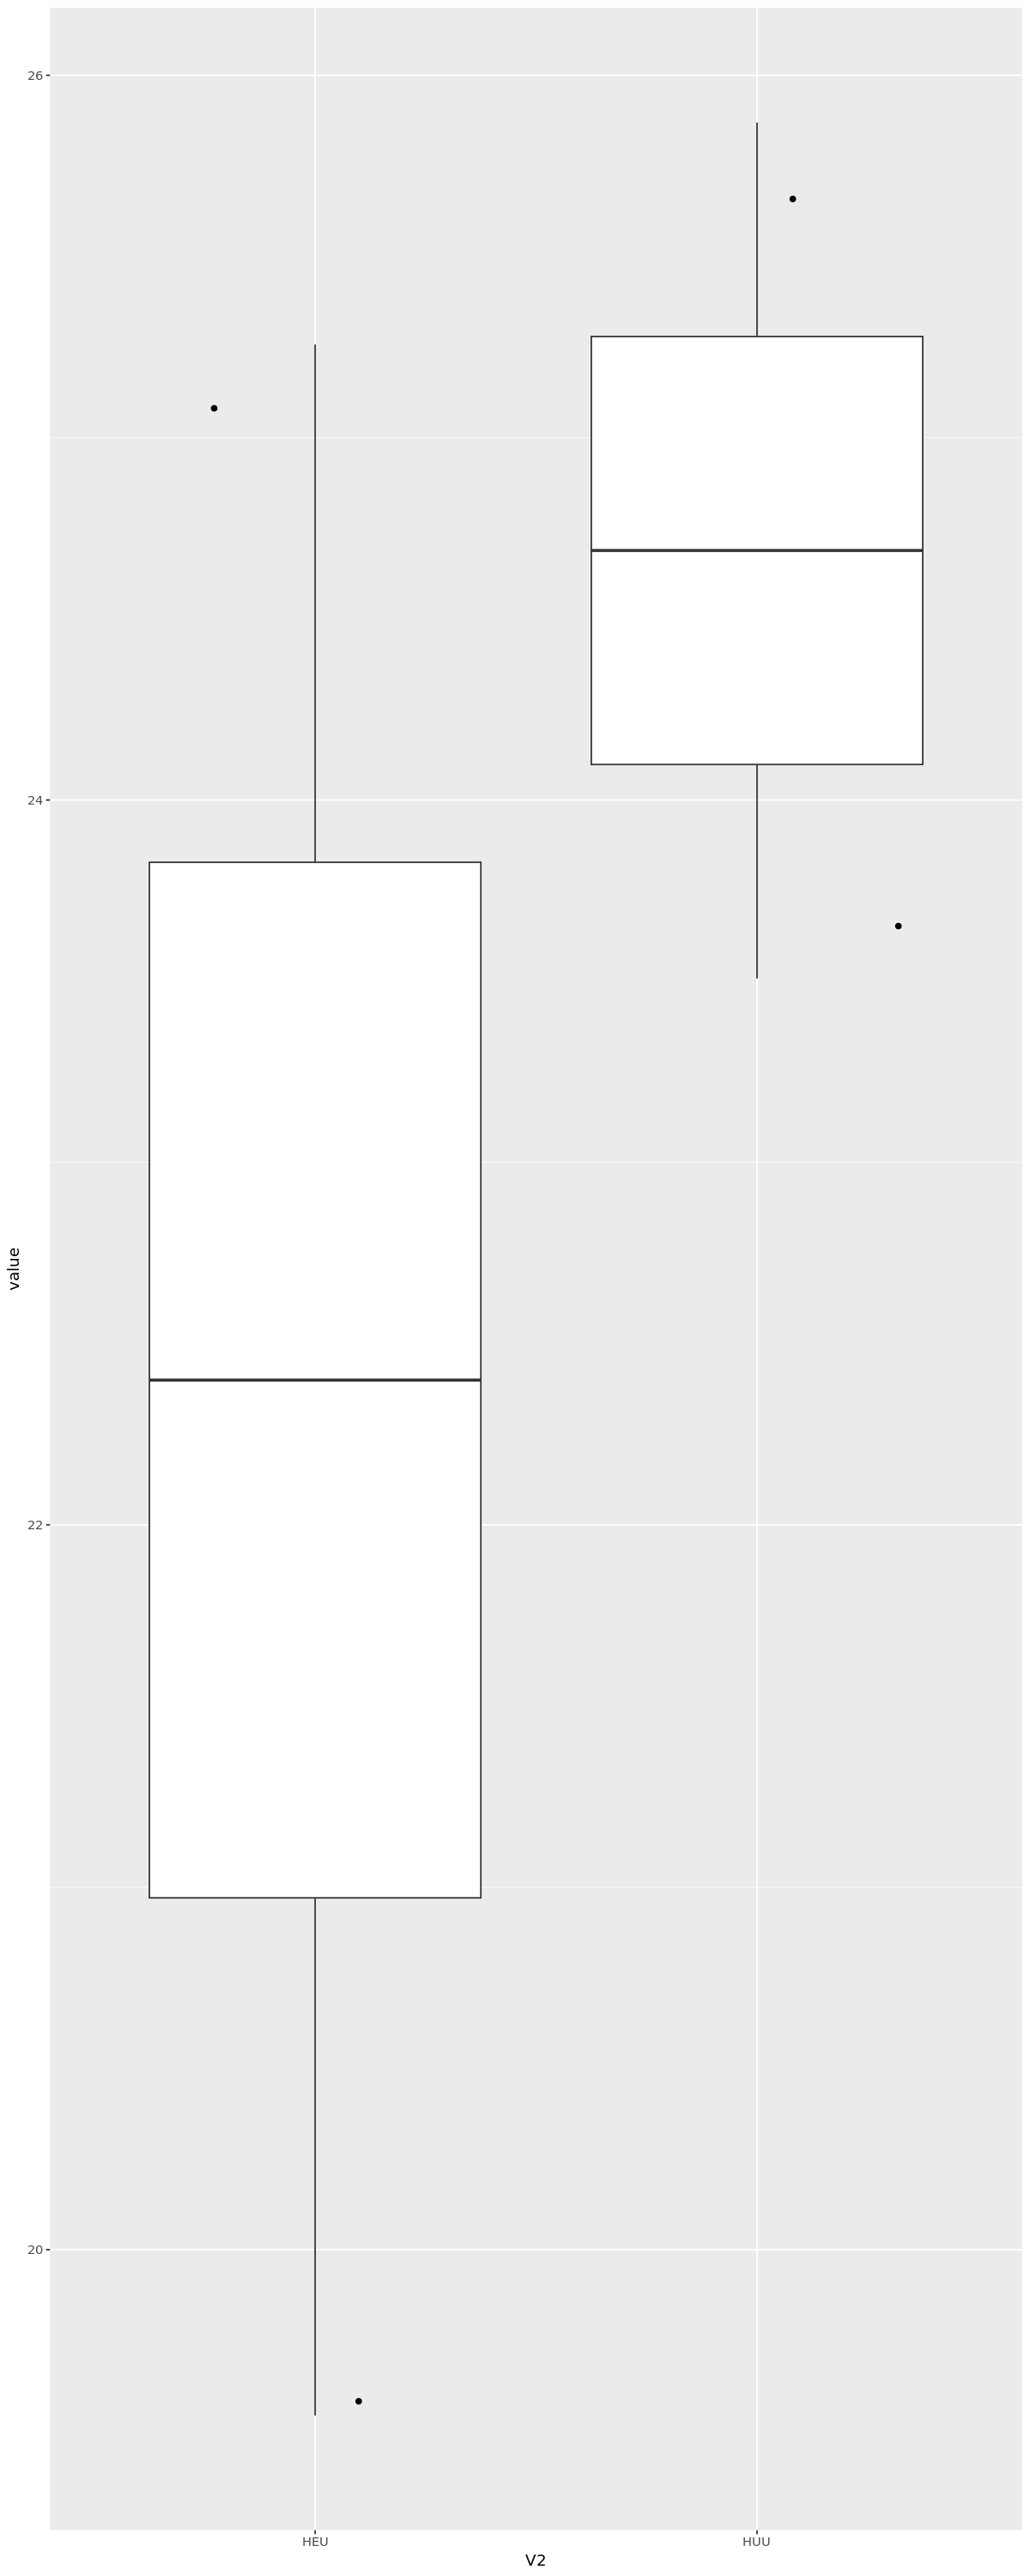

In [44]:
ps.dat.h <- subset_samples(ps.dat, aliquot_type=="H-CE")
# pull metadata table
map <- sample_data(ps.dat.h)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.HCE.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    IQR = IQR(value, na.rm = TRUE)
)

# are they different?
# wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
# wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
# wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
                
# boxplots
pdf("img/volatility.bplot.v1v3.HCE.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()  

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


png 
  2

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


V2,count,mean,IQR
<chr>,<int>,<dbl>,<dbl>
HEU,1,17.41136,0.000000
HI,6,24.22983,5.013953
HUU,2,20.37178,2.202055



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 9, p-value = 0.4286
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HI", ]$value and dist_diff[dist_diff$V2 == "HEU", ]$value
W = 6, p-value = 0.2857
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  dist_diff[dist_diff$V2 == "HEU", ]$value and dist_diff[dist_diff$V2 == "HUU", ]$value
W = 0, p-value = 0.6667
alternative hypothesis: true location shift is not equal to 0


png 
  2

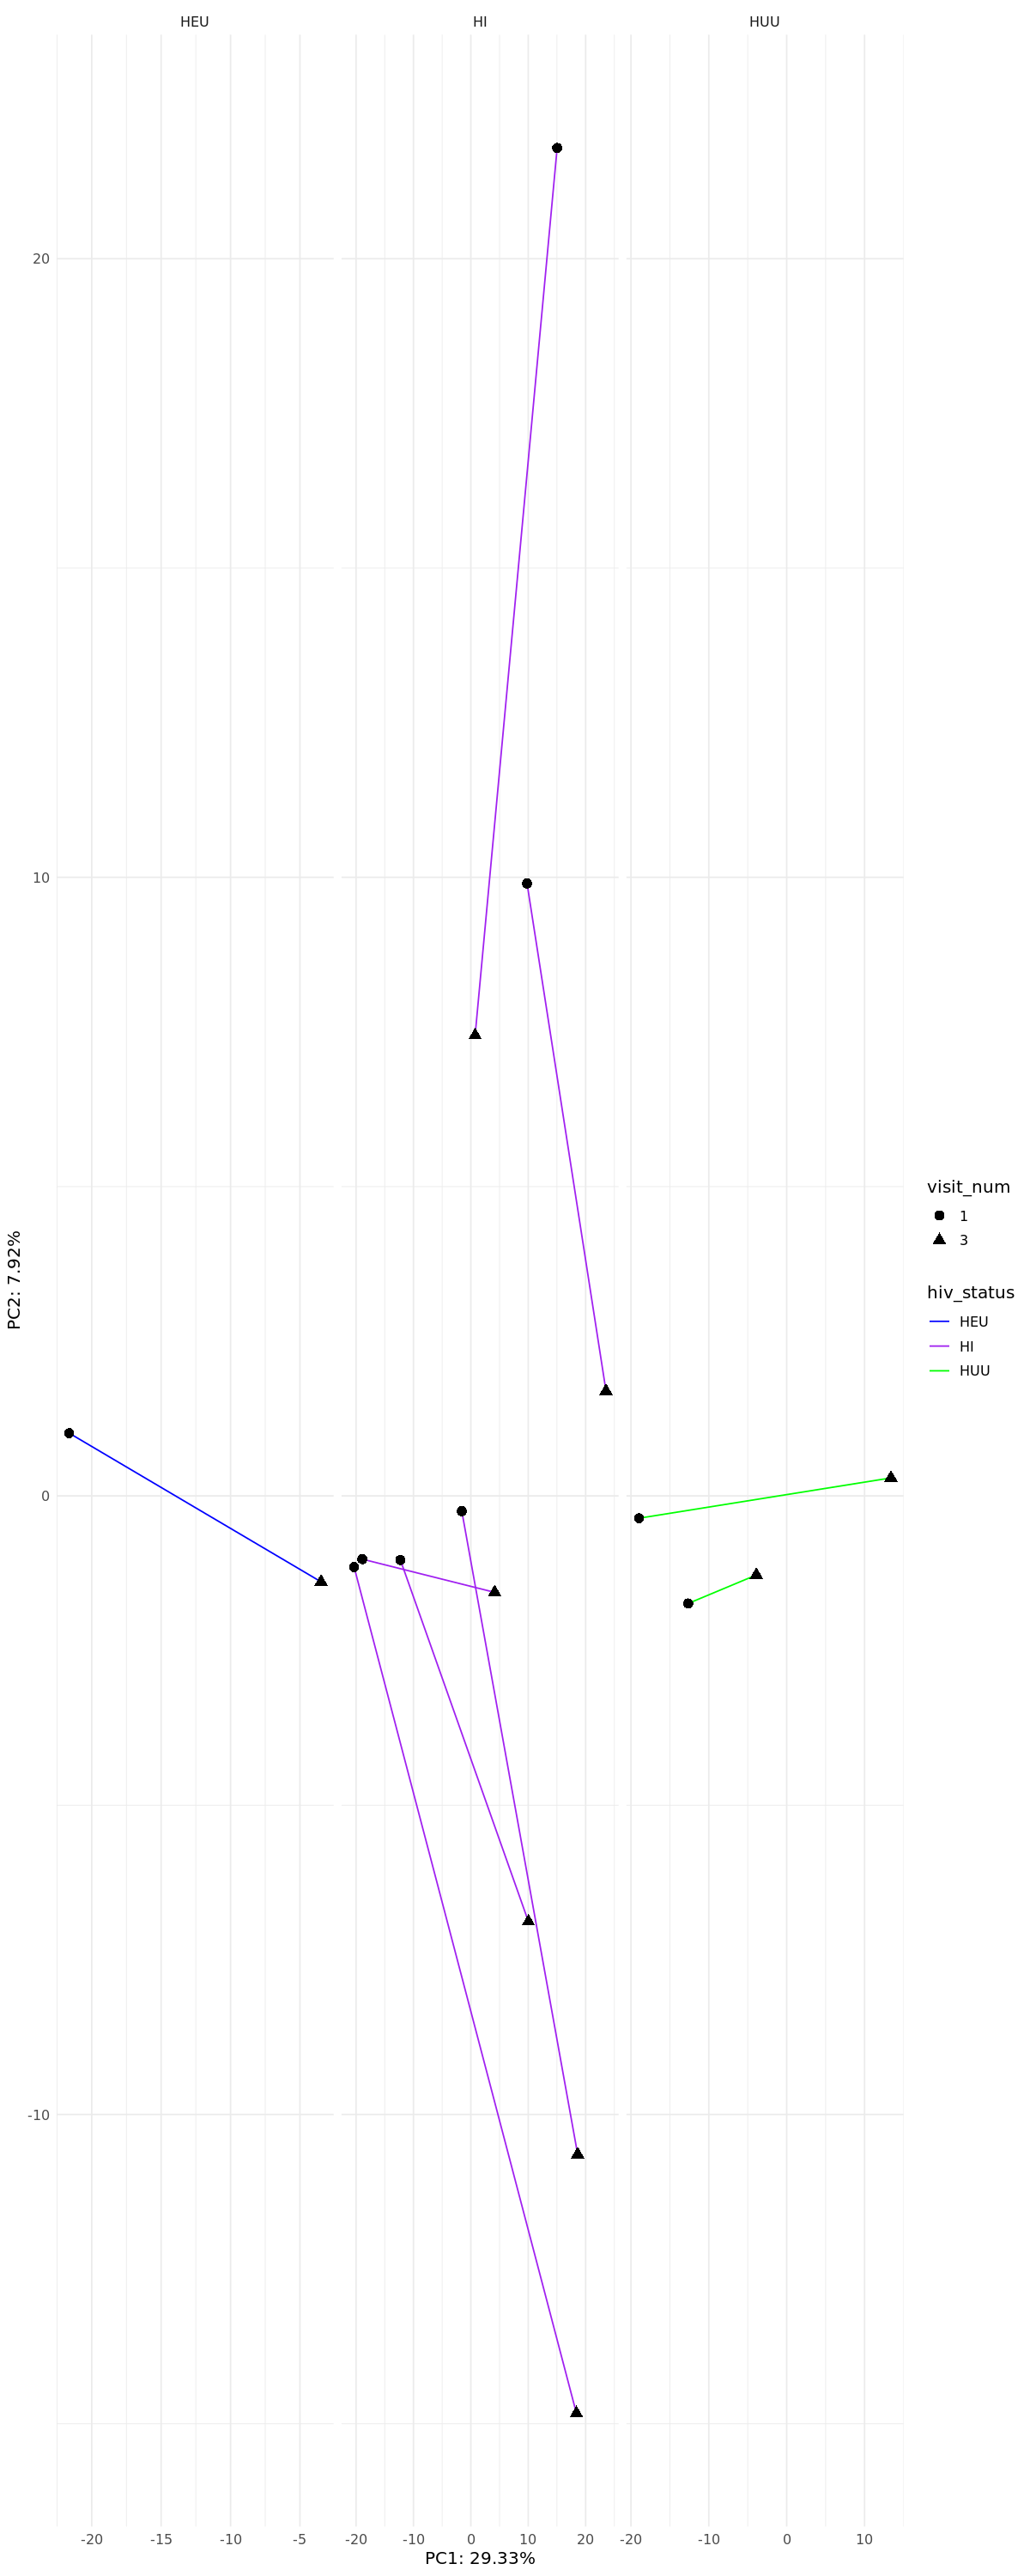

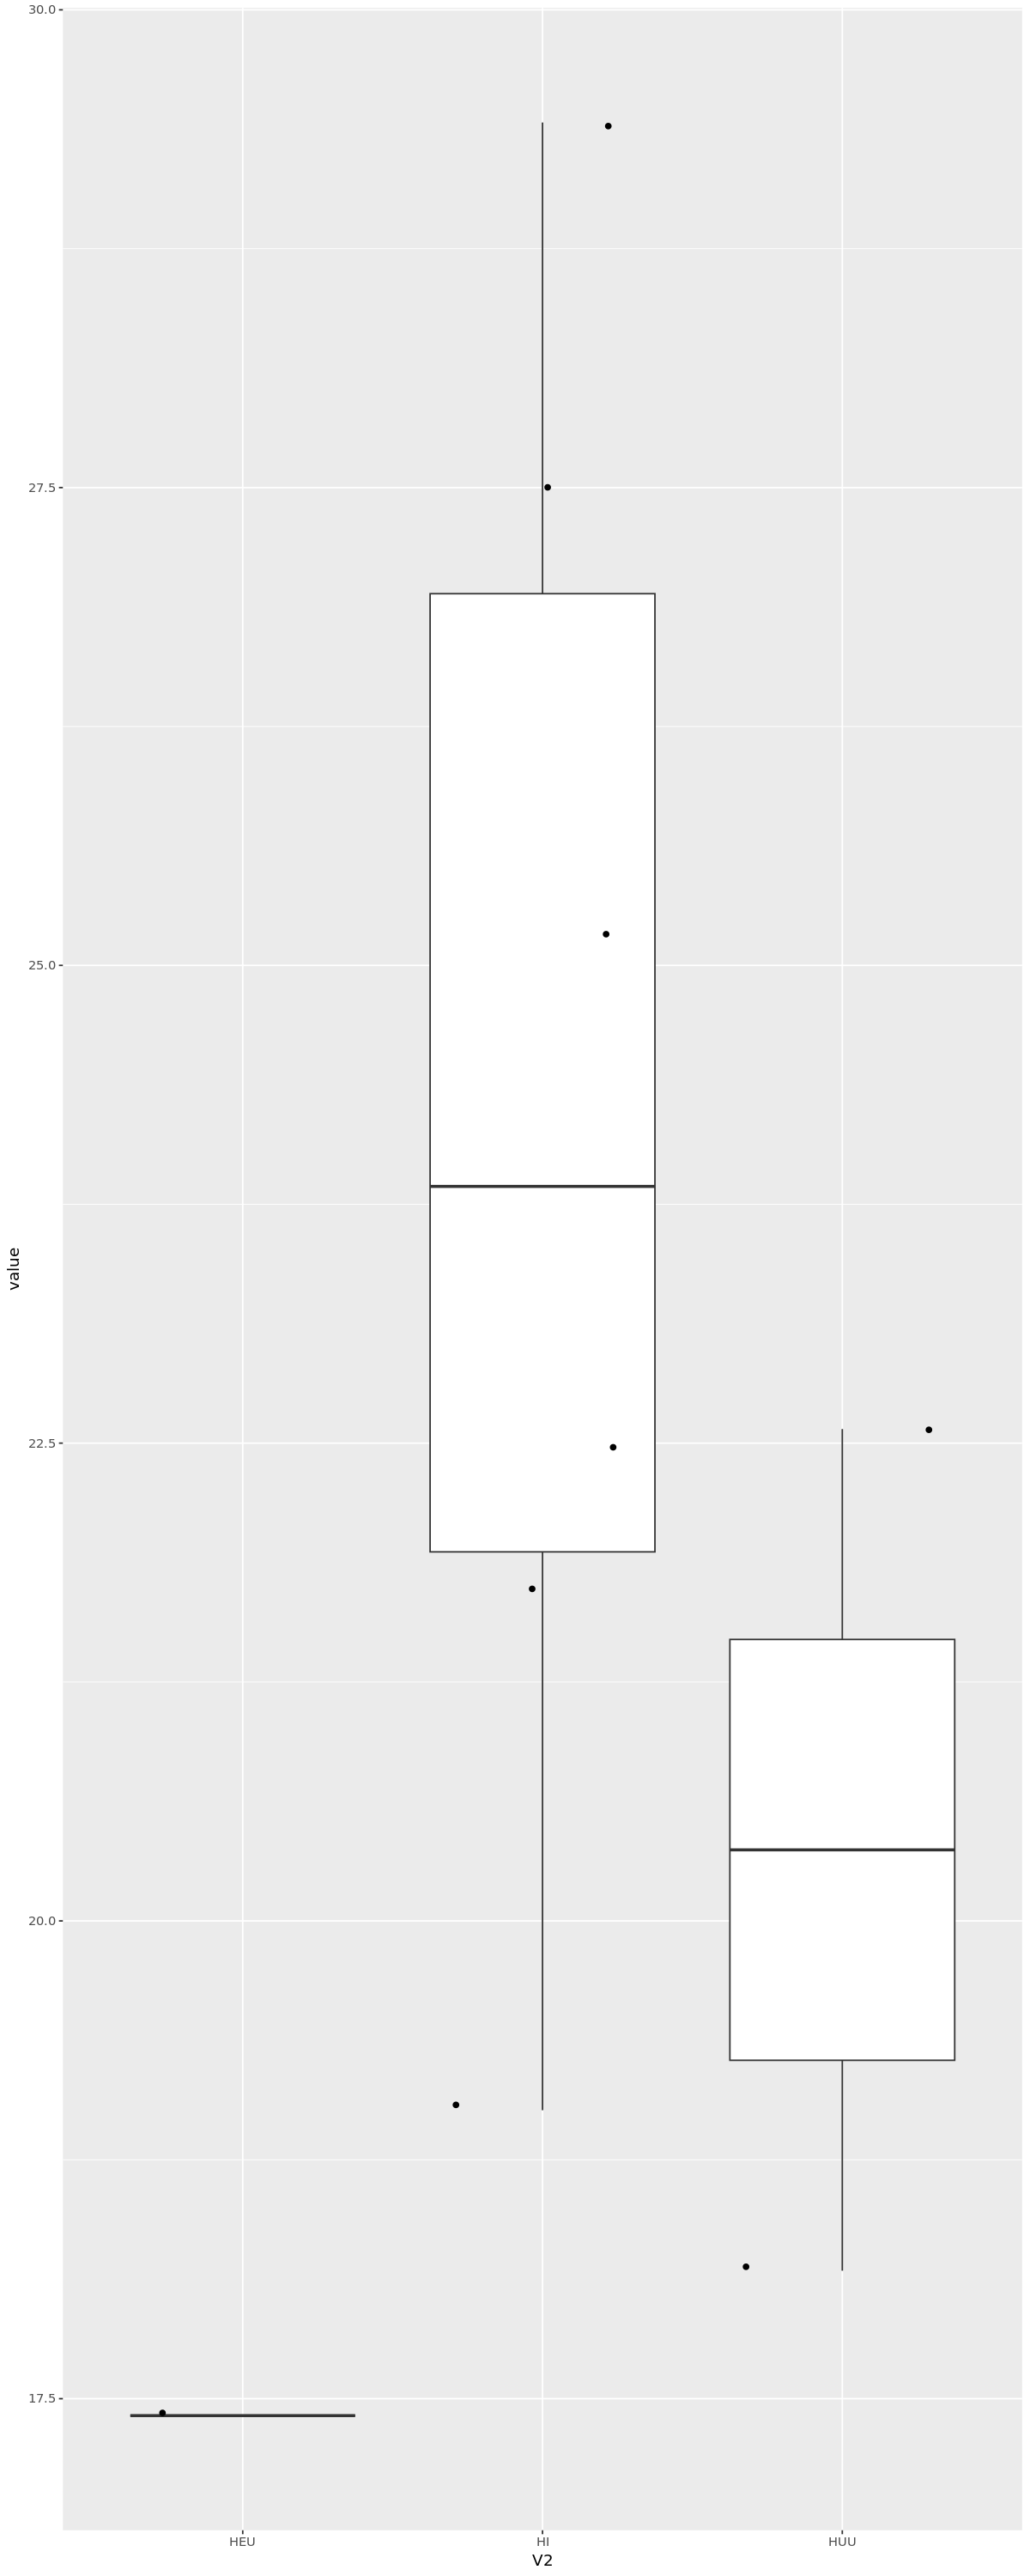

In [45]:
ps.dat.h <- subset_samples(ps.dat, aliquot_type=="H-CD")
# pull metadata table
map <- sample_data(ps.dat.h)
# this should look similar to the processing steps above. Basically want to create a new ASV table with duplicate samples across visit one and visit three
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
counts <- data.frame(table(map.v1v3$studyID_FDI))
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
counts <- counts[,colSums(counts) > 0]
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])

# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

pdf("img/volplot.pca.v1v3.HCD.pdf")
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
dev.off()
                
ggplot(pca, aes(x = PC1,
                y = PC2,
                colour = hiv_status,
                shape = visit_num,
                group = studyID_FDI)) +  
geom_line() +
geom_point(size = 3, col = "black") +
facet_wrap(~hiv_status, scales = "free_x", strip.position = "top") +
scale_fill_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
scale_colour_manual(values=c("HI"="purple", "HEU"="blue", "HUU"="green")) +
theme_minimal() +
xlab(paste("PC1: ", pc1,  "%", sep="")) +
ylab(paste("PC2: ", pc2,  "%", sep="")) +
theme(text = element_text(size = 12)) +
guides(fill = guide_legend(override.aes = list(shape = 22)))
                
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
library(reshape2)
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
library(dplyr)
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    mean = mean(value, na.rm = TRUE),
    IQR = IQR(value, na.rm = TRUE)
)

# are they different?
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HI",]$value, dist_diff[dist_diff$V2 == "HEU",]$value)
wilcox.test(dist_diff[dist_diff$V2 == "HEU",]$value, dist_diff[dist_diff$V2 == "HUU",]$value)
                
# boxplots
pdf("img/volatility.bplot.v1v3.HCD.pdf")
ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()
dev.off()

ggplot(dist_diff, aes(x=V2, y=value)) + geom_boxplot() + geom_jitter()  

As somewhat expected, we do not have enough samples from these categories to make any meaningful inference

Some notes: maybe ability to adapt to rapidly changing environment (as you might expect in the mouth) is associated with oral health? In other words, the lower volatility in HI and HEU might be a symptom of inability to adapt? And HUU are better able to adapt to rapidly changing environmental conditions? Maybe stability is more important in other microbiome habitats (e.g., the gut) as compared to the oral cavity?

### 3.7. Volatility by health status (not HIV category)

In [46]:
## TO DO: MAKE VOLATILITY PLOTS OUT OF TOOTH HEALTH CATEGORIES (IF THEY ARE CONSISTENT OVER TIME) -- HCF VERSUS EVERY ONE ELSE

## 4. Beta dispersal

Look at differences in beta dispersal metrics by tooth type, split by HIV category over all three visits

In [47]:
# get Aitchison distance matrix for each visit
clr.dist.hi <- dist(clr(otu_table(subset_samples(ps.dat, hiv_status=="HI"))), 
     method="euclidean")
clr.dist.heu <- dist(clr(otu_table(subset_samples(ps.dat, hiv_status=="HEU"))), 
     method="euclidean")
clr.dist.huu <- dist(clr(otu_table(subset_samples(ps.dat, hiv_status=="HUU"))), 
     method="euclidean")

In [48]:
# filter distance matrix by visit number
dispr <- vegan::betadisper(clr.dist.hi, 
                  sample_data(subset_samples(ps.dat, hiv_status=="HI"))$visit_num)
dispr
vegan::permutest(dispr)
dispr <- vegan::betadisper(clr.dist.heu, 
                  sample_data(subset_samples(ps.dat, hiv_status=="HEU"))$visit_num)
dispr
vegan::permutest(dispr)
dispr <- vegan::betadisper(clr.dist.huu, 
                  sample_data(subset_samples(ps.dat, hiv_status=="HUU"))$visit_num)
dispr
vegan::permutest(dispr)


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist.hi, group =
sample_data(subset_samples(ps.dat, hiv_status == "HI"))$visit_num)

No. of Positive Eigenvalues: 734
No. of Negative Eigenvalues: 0

Average distance to median:
    1     2     3 
15.83 17.73 17.16 

Eigenvalues for PCoA axes:
(Showing 8 of 734 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
 3505  2830  1846  1558  1451  1392  1317  1298 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      2   490.6 245.280 15.461    999  0.001 ***
Residuals 732 11612.9  15.865                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist.heu, group =
sample_data(subset_samples(ps.dat, hiv_status == "HEU"))$visit_num)

No. of Positive Eigenvalues: 610
No. of Negative Eigenvalues: 0

Average distance to median:
    1     2     3 
16.17 18.05 17.79 

Eigenvalues for PCoA axes:
(Showing 8 of 610 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
 3540  2314  1751  1431  1308  1299  1195  1122 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      2  439.9 219.931 13.458    999  0.001 ***
Residuals 608 9935.9  16.342                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist.huu, group =
sample_data(subset_samples(ps.dat, hiv_status == "HUU"))$visit_num)

No. of Positive Eigenvalues: 613
No. of Negative Eigenvalues: 0

Average distance to median:
    1     2     3 
16.31 17.81 17.17 

Eigenvalues for PCoA axes:
(Showing 8 of 613 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
 3197  1903  1769  1478  1453  1301  1263  1204 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq Mean Sq      F N.Perm Pr(>F)   
Groups      2   239.4 119.700 6.3056    999  0.004 **
Residuals 611 11598.8  18.983                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In general, does beta dispersity increase over time?

In [49]:
clr.dist <- dist(clr(otu_table(ps.dat)), 
     method="euclidean")

In [50]:
dispr <- vegan::betadisper(clr.dist, 
                  sample_data(ps.dat)$visit_num)
dispr
vegan::permutest(dispr)


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist, group =
sample_data(ps.dat)$visit_num)

No. of Positive Eigenvalues: 1959
No. of Negative Eigenvalues: 0

Average distance to median:
    1     2     3 
16.11 17.89 17.40 

Eigenvalues for PCoA axes:
(Showing 8 of 1959 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
 9169  5873  4444  3481  2957  2626  2488  2267 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups       2   1154  577.01 33.812    999  0.001 ***
Residuals 1957  33396   17.06                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

By age?

In [51]:
dispr <- vegan::betadisper(clr.dist, 
                  sample_data(ps.dat)$age_y)
dispr
vegan::permutest(dispr)


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = clr.dist, group =
sample_data(ps.dat)$age_y)

No. of Positive Eigenvalues: 1959
No. of Negative Eigenvalues: 0

Average distance to median:
   10    11     3     4     5     6     7     8     9 
17.66 17.87 13.58 15.77 15.57 17.01 17.19 17.77 17.95 

Eigenvalues for PCoA axes:
(Showing 8 of 1959 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
 9169  5873  4444  3481  2957  2626  2488  2267 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups       8   1890 236.216 14.209    999  0.001 ***
Residuals 1951  32435  16.625                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1